# Project Milestone 2

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import unicodedata
import re
import csv
import os 
import io
import pycld2 as cld2
import pycountry as py 
import pycountry_convert as pc 
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# conda install -c conda-forge pycld2
# !pip install pycountry-convert

---
## Importing datasets


In [13]:
current_dir = os.getcwd()
parent_folder_path = os.path.abspath(os.path.join(current_dir, ".."))
data_path = os.path.join(parent_folder_path, "data")

path_ba = data_path + '/BeerAdvocate'
path_rb = data_path + '/RateBeer'
path_mbd = data_path + '/matched_beer_data'

beers_ba = pd.read_csv(f"{path_ba}/{'beers.csv'}")
users_ba = pd.read_csv(f"{path_ba}/{'users.csv'}")
breweries_ba = pd.read_csv(f"{path_ba}/{'breweries.csv'}")

beers_rb = pd.read_csv(f"{path_rb}/{'beers.csv'}")
users_rb = pd.read_csv(f"{path_rb}/{'users.csv'}")
breweries_rb = pd.read_csv(f"{path_rb}/{'breweries.csv'}")  

ratings_mbd = pd.read_csv(f"{path_mbd}/{'ratings.csv'}", header = 1)  
beers_mbd = pd.read_csv(f"{path_mbd}/{'beers.csv'}", header = 1) 
breweries_mbd = pd.read_csv(f"{path_mbd}/{'breweries.csv'}", header = 1) 
users_mbd = pd.read_csv(f"{path_mbd}/{'users.csv'}", header = 1) 

In [28]:
# Main problem is the length of the txt file 
# We will iterate each line, one by one, to avoid memory saturation 

# Open, read only, utf-8 for specific characters 

def txt_to_csv(path,name):

    if os.path.exists(f"{path}/{name}.csv"):
        print(f"{name}.csv is already present in the folder")
        return  # Exit the function
    
    
    with gzip.open(f'{path}/{name}.txt.gz', 'rt', encoding='utf-8') as text_file:
        # Create a CSV file
        with open(f'{path}/{name}.csv', 'w', newline='', encoding='utf-8') as csv_file:
            # CSV
            csv_writer = csv.writer(csv_file)
        
            # Dictionnary
            data = {}
            total_lines = 0
            headers_created = False

            # Each line of txt
            for line in text_file:
                line = line.strip()

                if not line: # when there is no line, then add retrieved elements to one row in the CSV
                    if data:
                        
                        if not headers_created:
                            # Create headers with keys from dictionnary
                            headers = list(data.keys())
                            csv_writer.writerow(headers)
                            headers_created = True


                        # Write the data to the CSV
                        row = [data.get(header, "") for header in headers]
                        csv_writer.writerow(row)
                        data = {}
                        total_lines += 1
                else:
                    # Check if the line contains the separator ": "
                    if ": " in line:
                        key, value = line.split(": ", 1)
                        data[key] = value
                    else:
                        pass

            # Last writing
            if data:
                row = [data.get(header, "") for header in headers]
                csv_writer.writerow(row)
                total_lines += 1

    print(f"Total number of comments : {total_lines}")
    print(f"Saved as {name}.csv in {path}")


In [30]:
# Give the path_ ba, rb, mbd and the name of the file without the type.
# Convert Beeradvocate reviews to csv 
txt_to_csv(path_ba,"reviews")

Total number of comments : 2589586
Saved as reviews.csv in /Users/thomas/Desktop/ADA/Beer/data/BeerAdvocate


In [5]:
# Convert Beeradvocate ratings to csv
txt_to_csv(path_ba,"ratings")

ratings.csv is already present in the folder


In [6]:
reviews_ba = pd.read_csv(f"{path_ba}/reviews.csv", nrows=100)
reviews_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....."


In [7]:
ratings_ba = pd.read_csv(f"{path_ba}/ratings.csv", nrows=100)
ratings_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True


In [31]:
txt_to_csv(path_rb,"reviews")
txt_to_csv(path_rb,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


We can see that reviews.txt and ratings.txt extracted from RateBeer are identicals text files simply because "*on RateBeer, you are required to write at least 75 characters describing the beer, and you must give it five different numeric ratings.*" In further analysis, we will simply use ratings.txt

In [4]:
reviews_rb = pd.read_csv(f"{path_rb}/reviews.csv", nrows=100)
reviews_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


In [10]:
ratings_rb = pd.read_csv(f"{path_rb}/ratings.csv", nrows=100)
ratings_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


In [14]:
# deep copies of all dataframes 
beers_ba_f = beers_ba.copy(deep=True)
users_ba_f = users_ba.copy(deep=True)
breweries_ba_f = breweries_ba.copy(deep=True)

beers_rb_f = beers_rb.copy(deep=True)
users_rb_f = users_rb.copy(deep=True)
breweries_rb_f = breweries_rb.copy(deep=True)

ratings_mbd_f = ratings_mbd.copy(deep=True)
breweries_mbd_f = breweries_mbd.copy(deep=True)
beers_mbd_f = beers_mbd.copy(deep=True)
users_mbd_f = users_mbd.copy(deep=True)

# 1.  Data observation 

In [181]:
display(beers_ba_f)


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,bigger_style
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),euro pale lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,Pale Lagers
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),euro pale lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN,Pale Lagers
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),euro pale lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN,Pale Lagers
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),euro pale lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,Pale Lagers
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),euro pale lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN,Pale Lagers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,kölsch,3,3,2.71,NaN,NaN,5.0,2.713333,NaN,0,NaN,Pale Ales
280819,19140,Nut Brown Ale,885,Summit Station Restaurant & Brewery,english brown ale,2,1,3.10,NaN,NaN,5.3,3.250000,NaN,0,NaN,Brown Ales
280820,19146,Octoberfest,885,Summit Station Restaurant & Brewery,märzen / oktoberfest,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Dark Lagers
280821,2805,Scotch Ale,885,Summit Station Restaurant & Brewery,scotch ale / wee heavy,0,0,NaN,NaN,NaN,7.0,NaN,NaN,0,NaN,Strong Ales


In [182]:
display(beers_rb_f)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442076,189684,Stela Selekt,1107,Stefani & Co,Pilsener,5,NaN,NaN,2.19,4.7,1.500000,NaN,0,NaN
442077,84884,Hotel Martini Donauer,9355,Hotel Martini,Pale Lager,1,NaN,NaN,2.77,NaN,2.900000,NaN,0,NaN
442078,93783,Birra Rozafa,9928,Rozafa Brewery,Pale Lager,1,NaN,NaN,2.64,NaN,2.000000,NaN,0,NaN
442079,220897,Svejk Blonde,17155,Svejk Beer Garden,Pale Lager,4,NaN,NaN,2.70,NaN,2.500000,NaN,0,NaN


In [183]:
display(breweries_ba_f)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16754,5023,Aruba,Aruba Brewing,0
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491
16756,16186,"United States, North Carolina",Triangle Brewing Company,20


In [64]:
display(breweries_rb_f)

,id,location,name,nbr_beers,countries
0,3198,Gabon,Sobraga,3,Gabon
1,13538,Northern Ireland,Ards Brewing Co.,13,Northern Ireland
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,Northern Ireland
3,22818,Northern Ireland,Boundary,66,Northern Ireland
4,24297,Northern Ireland,Brewbot Belfast,3,Northern Ireland
...,...,...,...,...,...
24184,28180,Albania,Shoqeria Picana,1,Albania
24185,1107,Albania,Stefani & Co,11,Albania
24186,9355,Albania,Hotel Martini,1,Albania
24187,9928,Albania,Rozafa Brewery,1,Albania


In [65]:
display(users_ba_f)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [66]:
display(users_rb_f)

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
...,...,...,...,...,...
70169,1,134893,stamfordbus,1.315217e+09,England
70170,1,327816,fobia405,1.406282e+09,Belgium
70171,1,183139,junkin,1.339841e+09,NaN
70172,3,82020,klesidra,1.222250e+09,Slovenia


In [6]:
beers_ba_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
nbr_reviews                       0
avg                           32829
ba_score                     219623
bros_score                   275121
abv                           36024
avg_computed                  32841
zscore                       240538
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    252551
dtype: int64

In [7]:
beers_rb_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
overall_score                338053
style_score                  338013
avg                           46424
abv                           42094
avg_computed                  45391
zscore                       399853
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    399853
dtype: int64

In [11]:
breweries_ba_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [10]:
breweries_rb_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [67]:
users_ba_f.isna().sum()

nbr_ratings        0
nbr_reviews        0
user_id            0
user_name          1
joined          2652
location       31279
dtype: int64

In [68]:
users_rb_f.isna().sum()

nbr_ratings        0
user_id            0
user_name          0
joined            30
location       19582
dtype: int64

### Matched beer data files 

In [95]:
print('Size of beers file: ', beers_mbd_f.shape)
print('Size of breweries file: ', breweries_mbd_f.shape)
print('Size of users file: ', users_mbd_f.shape)

Size of beers file:  (45640, 33)
Size of breweries file:  (8281, 10)
Size of users file:  (3020, 13)


Noticing the small size of the matched beer data files compared to the individual files for RateBbeer and BeerAdvocate, we decide to study the other files instead if these the matched ones. 

# 2. Basic metrics to measure the trend of a beer 

In this part we will have a look at different variables such as the number of ratings, the styles of beers, the scores, the average across all ratings. First, we will have a look at them individually and see if there are any correlations between them. Secondly, we will study them regarding the location variable. 

### Number of ratings 

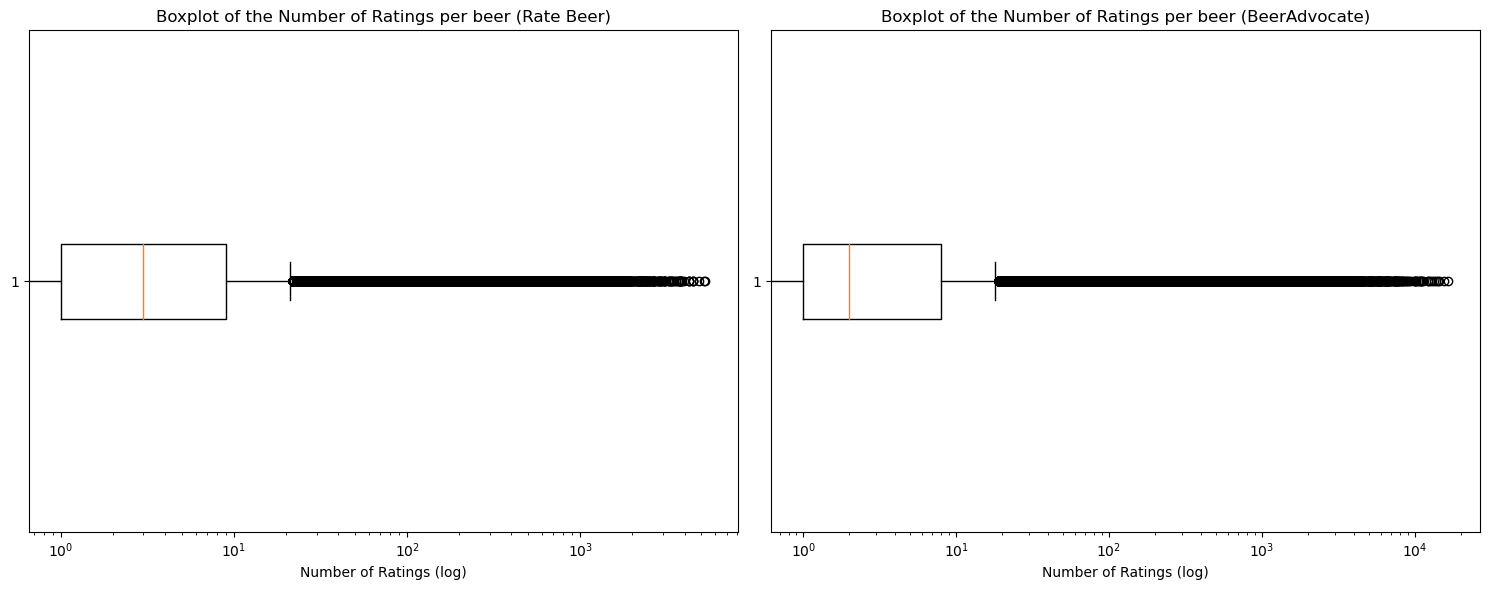

In [20]:
# Number of ratings per beer 
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.boxplot(beers_rb_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (Rate Beer)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.boxplot(beers_ba_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (BeerAdvocate)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.tight_layout()
plt.show()

As we can see the mean number of ratings per beer for both sites is pretty low. However, there are a lot of beers that receives a huge number of ratings on both sites, suggesting that some beers stand out from others. 

### Styles of beer

In [57]:
# Number of styles of beers 
nbr_style_ba = beers_ba_f['style'].value_counts().nlargest(15)
nbr_style_rb = beers_rb_f['style'].value_counts().nlargest(15)
nbr_style_mbd = ratings_mbd_f['style'].value_counts().nlargest(15)

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_848/2268478819.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


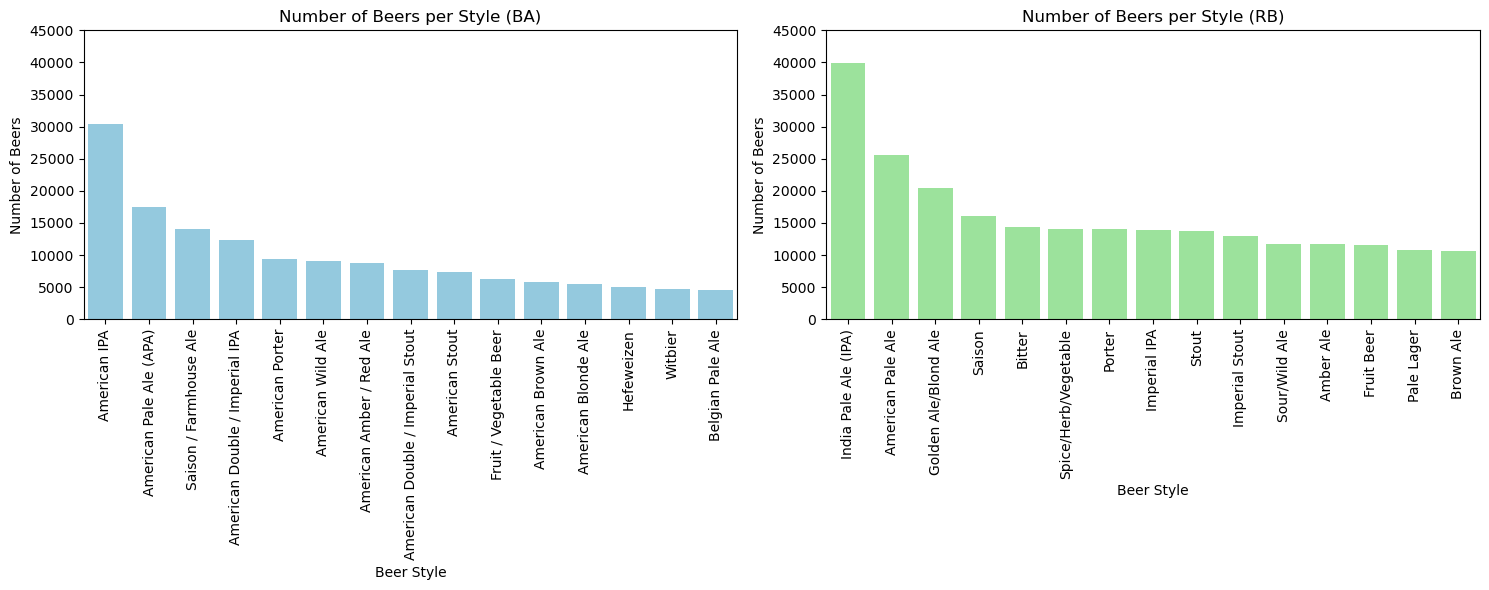

In [68]:
plt.figure(figsize=(15, 6))

# Number of styles of beers for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=nbr_style_ba.index, y=nbr_style_ba.values, color='skyblue')
plt.title('Number of Beers per Style (BA)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

# Number of styles of beers for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x=nbr_style_rb.index, y=nbr_style_rb.values, color='lightgreen')
plt.title('Number of Beers per Style (RB)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

plt.show()

#plt.subplot(1, 3, 3)
#nbr_style_mbd.plot(kind='bar', color='lightcoral', edgecolor='black')
#plt.title('Number of Beers per Style (MBD)')
#plt.xlabel('Beer Style')
#plt.ylabel('Number of Beers')
#plt.xticks(rotation=90)
#plt.ylim(0, max_value)  

As we can see the two most represented styles on both sites are IPA beers. 

### Number of ratings per style of beer

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

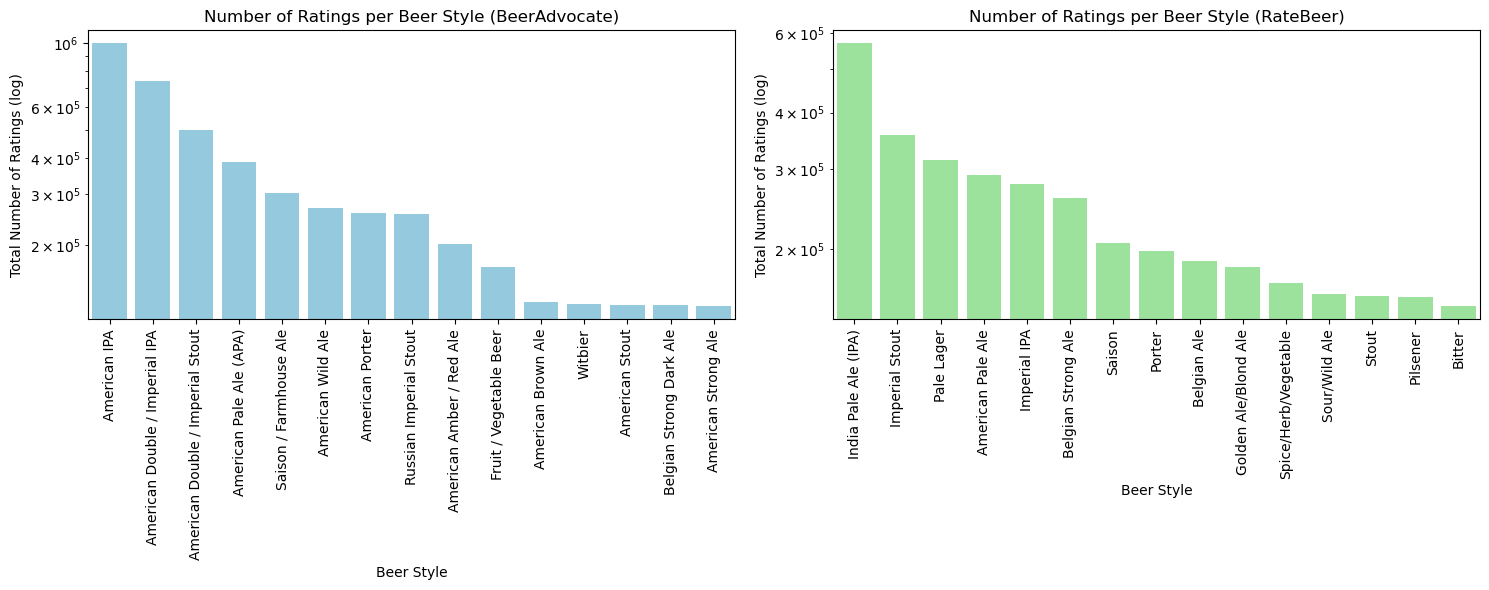

In [63]:
# Number of ratings per beer style for BeerAdvocate
ba_ratings_style = beers_ba_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
ba_ratings_style = ba_ratings_style.sort_values(by='nbr_ratings', ascending=False)
ba_ratings_style= ba_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

# Number of ratings per beer style for RateBeer
rb_ratings_style = beers_rb_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
rb_ratings_style = rb_ratings_style.sort_values(by='nbr_ratings', ascending=False)
rb_ratings_style= rb_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

plt.figure(figsize=(15, 6))

# Plot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=ba_ratings_style, x='style', y='nbr_ratings', color='skyblue')
plt.title('Number of Ratings per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

# Plot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=rb_ratings_style, x='style', y='nbr_ratings', color='lightgreen')
plt.title('Number of Ratings per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

plt.show()

As we can see the most rated beer style is a type of IPA for both sites. Overall, having a first look at the style variable we can see that IPAs are greatly represented on BeerAdvocate and on RateBeer. 

In [ ]:
def categorize_style(style):
    style = style.lower()
    if any(substring in style for substring in ['bock', 'doppelbock', 'eisbock', 'maibock', 'weizenbock']):
        return 'Bocks'
    elif any(substring in style for substring in ['altbier', 'brown ale', 'irish ale', 'american brown ale', 'belgian dark ale', 'english brown ale', 'english dark mild ale']):
        return 'Brown Ales'
    elif any(substring in style for substring in ['dubbel', 'traditional ale', 'mild ale', 'landbier', 'keller', 'zwickel', 'black ale','american black ale','roggenbier', 'scottish ale', 'winter warmer']):
        return 'Dark Ales'
    elif any(substring in style for substring in ['american amber / red lager', 'amber lager/vienna', 'dunkel/tmavý', 'dortmunder', 'euro dark lager', 'czech amber lager', 'czech dark lager', 'european dark lager', 'märzen', 'munich dunkel', 'rauchbier', 'schwarzbier', 'vienna lager']):
        return 'Dark Lagers'
    elif any(substring in style for substring in ['bière de champagne / bière brut', 'california common', 'braggot', 'california common / steam beer', 'cream ale']):
        return 'Hybrid Beers'
    elif any(substring in style for substring in ['american ipa', 'india style lager', 'ipa','belgian ipa', 'black ipa', 'brut ipa', 'english ipa', '(ipa)', 'imperial ipa', 'milkshake ipa', 'new england ipa']):
        return 'India Pale Ales'
    elif any(substring in style for substring in ['american amber / red ale', 'amber ale', 'bitter', 'blond ale', 'american blonde ale', 'american pale ale', '(apa)','belgian blonde ale', 'belgian pale ale', 'bière de garde', 'english bitter', 'english pale ale', 'english pale mild ale', 'extra special / strong bitter (esb)', 'grisette', 'irish red ale', 'kölsch', 'saison']):
        return 'Pale Ales'
    elif any(substring in style for substring in ['american adjunct lager', 'czech pilsner', 'premium lager', 'pilsener', 'pale lager', 'euro strong lager','german pilsener', 'czech pilsener','american pale lager', 'euro pale lager', 'american lager', 'bohemian / czech pilsner', 'czech pale lager', 'european / dortmunder export lager', 'european pale lager', 'european strong lager', 'festbier / wiesnbier', 'german pilsner', 'helles', 'imperial pilsner', 'india pale lager (ipl)', 'kellerbier / zwickelbier', 'light lager', 'malt liquor']):
        return 'Pale Lagers'
    elif any(substring in style for substring in ['american porter', 'porter', 'baltic porter', 'english porter', 'imperial porter', 'robust porter', 'smoked porter']):
        return 'Porters'
    elif any(substring in style for substring in ['chile beer', 'mead', 'radler/shandy', 'cider', 'specialty grain', 'smoked', 'low alcohol', 'vegetable','herb', 'spice', 'herbed / spiced beer', 'pumpkin ale', 'fruit', 'fruit and field beer', 'gruit / ancient herbed ale', 'happoshu', 'herb and spice beer', 'japanese rice lager', 'kvass', 'low-alcohol beer', 'pumpkin beer', 'rye beer', 'sahti', 'smoked beer']):
        return 'Specialty Beers'
    elif any(substring in style for substring in ['american imperial stout', 'stout', 'milk / sweet stout','imperial stout', 'american stout', 'english stout', 'foreign / export stout', 'irish dry stout', 'oatmeal stout', 'russian imperial stout', 'sweet / milk stout']):
        return 'Stouts'
    elif any(substring in style for substring in ['american barleywine','barley wine', 'abt/quadrupel', 'scotch ale', 'belgian strong ale', 'belgian ale', 'belgian strong dark ale', 'american strong ale', 'belgian dark strong ale', 'belgian pale strong ale', 'english barleywine', 'english strong ale', 'imperial red ale', 'old ale', 'quadrupel (quad)', 'scotch ale / wee heavy', 'tripel', 'wheatwine']):
        return 'Strong Ales'
    elif any(substring in style for substring in ['american dark wheat beer', 'wheat ale', 'american dark wheat ale', 'american pale wheat beer', 'american pale wheat ale', 'dunkelweizen', 'grodziskie', 'hefeweizen', 'kristallweizen', 'witbier']):
        return 'Wheat Beers'
    elif any(substring in style for substring in ['berliner weisse', 'sour red/brown', 'berliner weissbier','brett beer', 'faro', 'flanders oud bruin', 'flanders red ale', 'fruit lambic', 'fruited kettle sour', 'gose', 'gueuze', 'lambic', 'wild ale']):
        return 'Wild/Sour Beers'
    else:
        return 'Other'

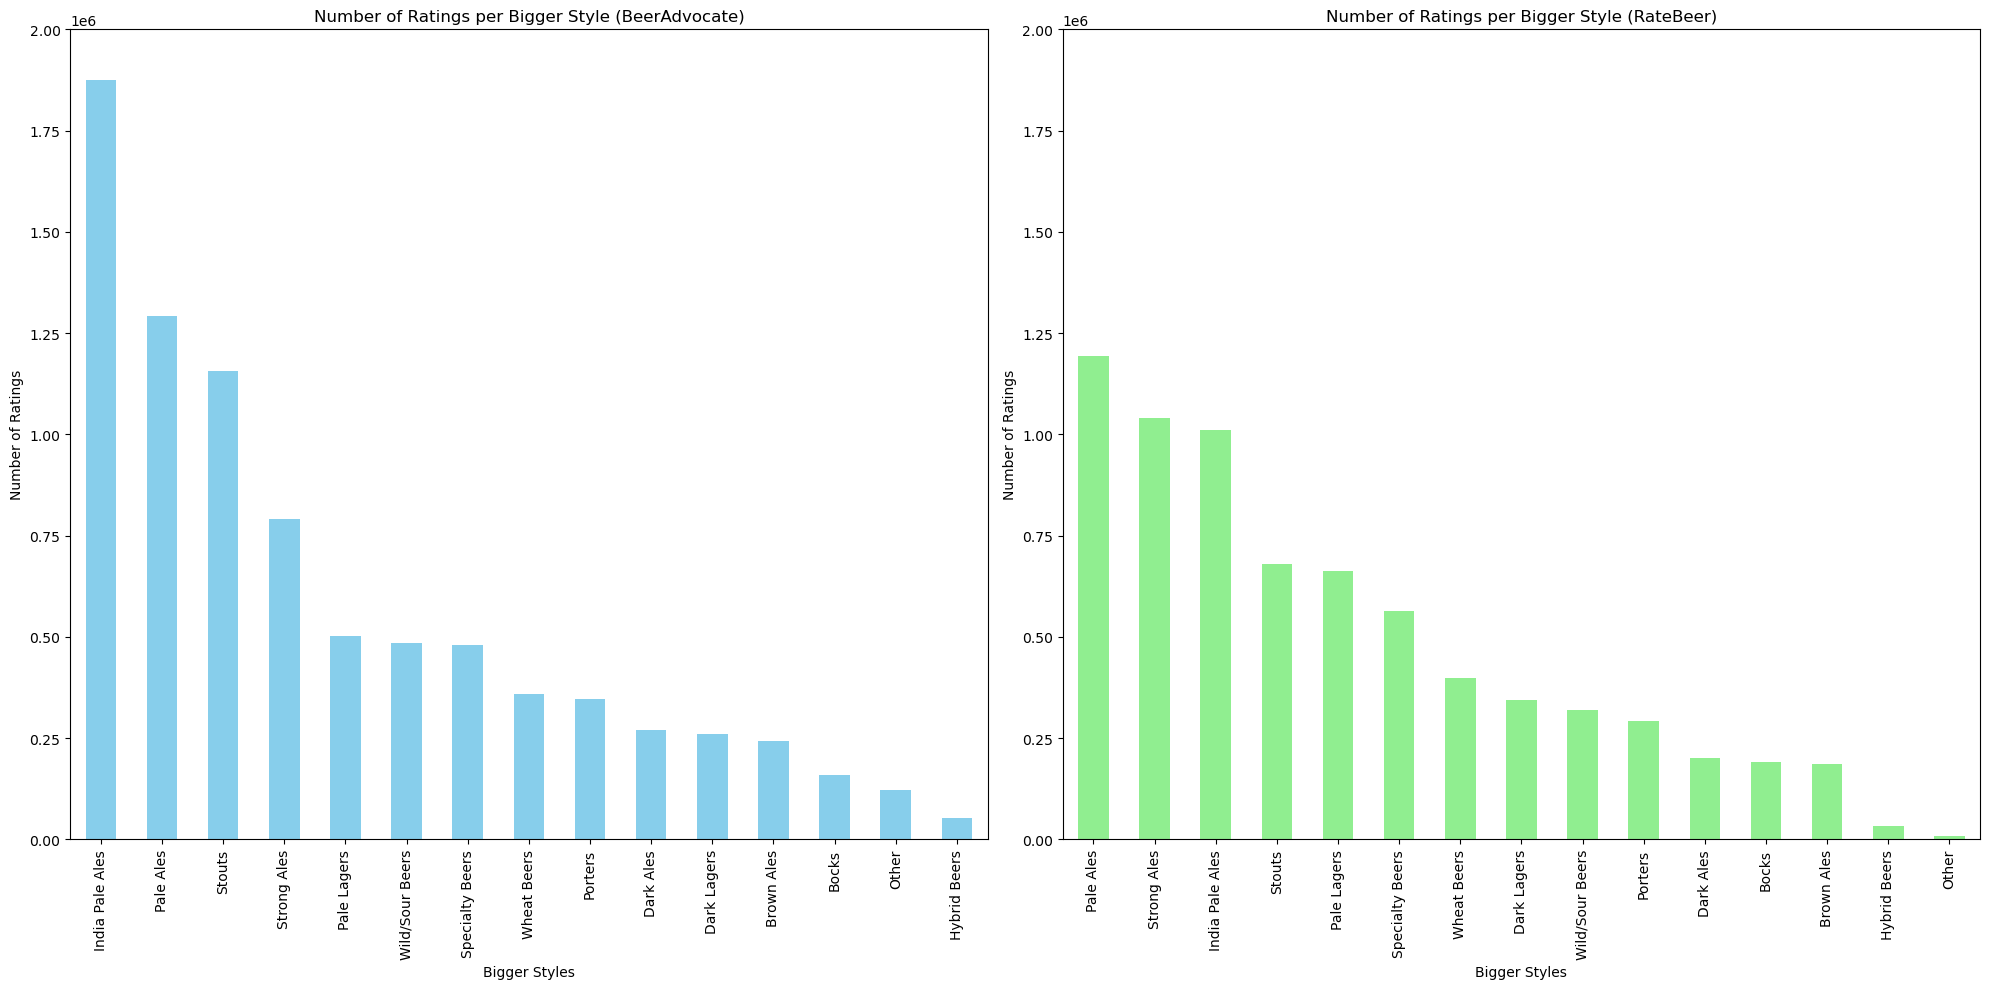

In [38]:
# Convert styles to lowercase 
beers_ba_f['style'] = beers_ba_f['style'].str.lower()
    
# Categorize each style with the Bigger styles of beer of each website 
beers_ba_f['bigger_style'] = beers_ba_f['style'].apply(categorize_style)
beers_rb_f['bigger_style'] = beers_rb_f['style'].apply(categorize_style)

ratings_per_bigger_style_ba = beers_ba_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)
ratings_per_bigger_style_rb = beers_rb_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(1,2,1)
ax1 = ratings_per_bigger_style_ba.plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Bigger Style (BeerAdvocate)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.ylim(0,2000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = ratings_per_bigger_style_rb.plot(kind='bar', color='lightgreen')
plt.title('Number of Ratings per Bigger Style (RateBeer)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.ylim(0,2000000)
plt.tight_layout()

plt.show()

Even when looking at a bigger picture, IPAs still are in the top 3 most rated beer style on both websites. Pales Ales, Stout and Strong Ales are also greatly represented on the websites. 

### Scores 

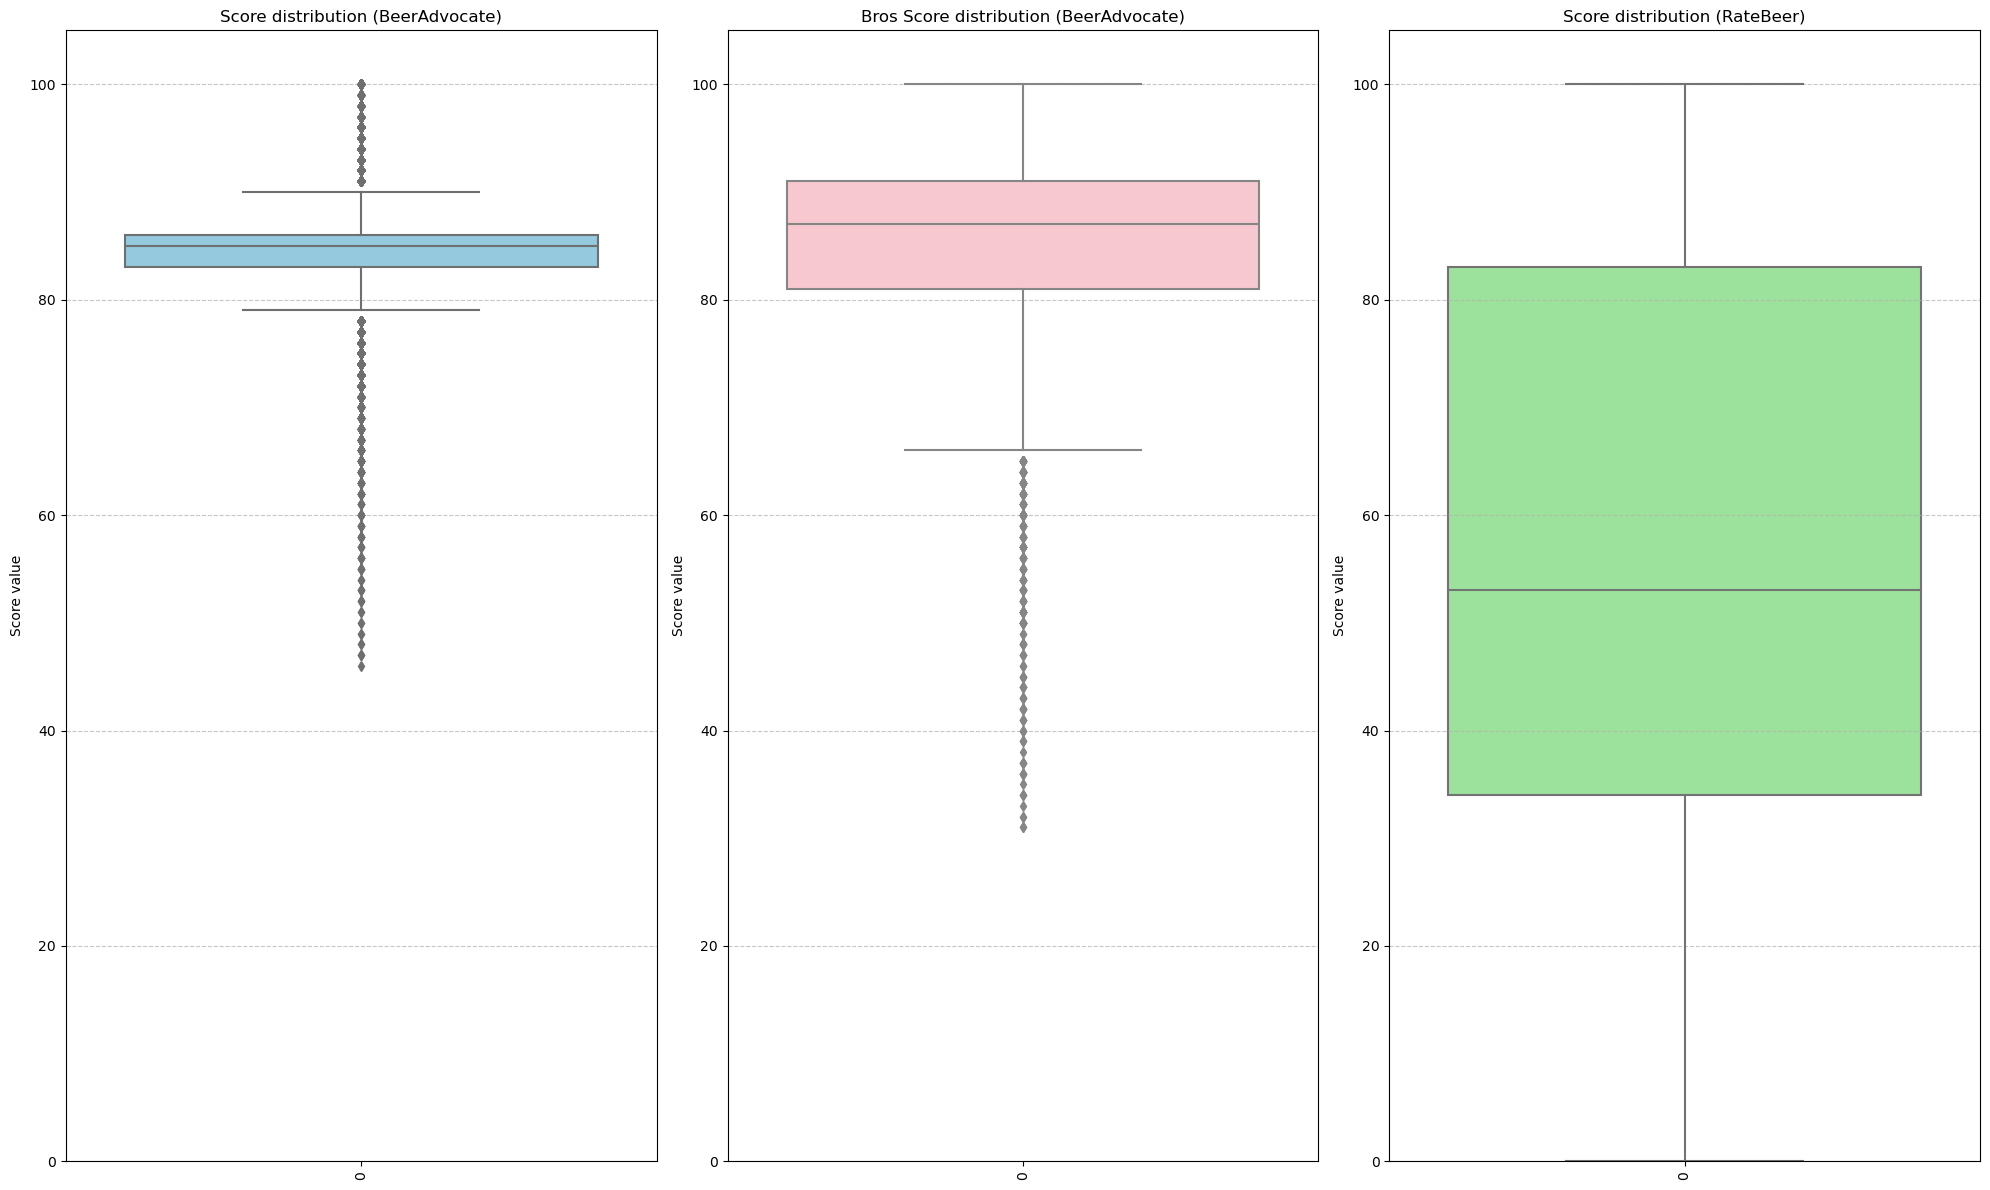

In [204]:
# Drop NA values for the scores 
beers_ba_f['ba_score'].dropna()
beers_rb_f['overall_score'].dropna()
beers_ba_f['bros_score'].dropna()

ba_score_count = beers_ba_f['ba_score'].value_counts()
rb_score_count = beers_rb_f['overall_score'].value_counts()
bros_score_count = beers_ba_f['bros_score'].value_counts()

plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
ax1 = sns.boxplot(beers_ba_f['ba_score'], color='skyblue')
plt.title('Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(beers_ba_f['bros_score'], color='pink')
plt.title('Bros Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(beers_rb_f['overall_score'], color='lightgreen')
plt.title('Score distribution (RateBeer)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

As we can see beers on BeerAdvocate tend to have higher scores than beers on RateBeer that have broader scores. So between these two websites it is hard to use the scores as a metric to evaluate the beer. However, the bros score on BeerAdvocate, which is the score that the founders of the website (so experts) give to the beers, can be a good metric to help us find define a trend. Indeed, we can see that the bros score is more spread out which might be a more accurate representation of the quality of the beer. This metric is only available on Beer Advocate. 

### Average score per style 

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_848/3452989156.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


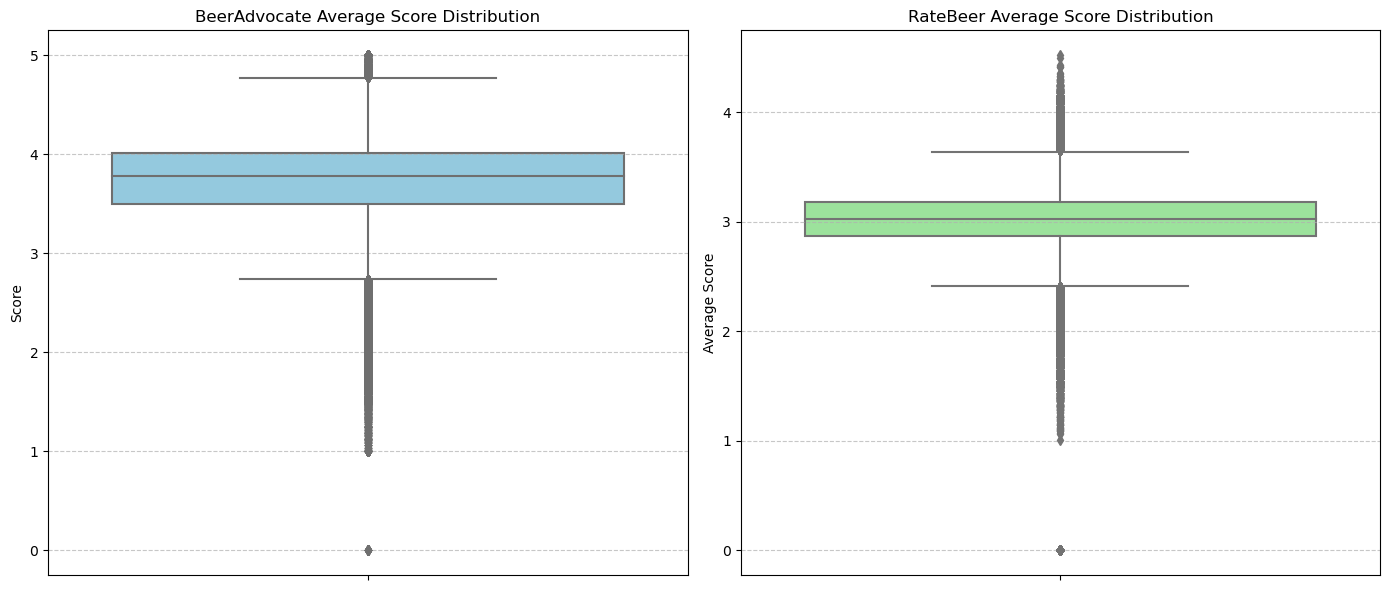

In [218]:
# Drop NA values for the average scores 
beers_ba_f['avg'].dropna()
beers_rb_f['avg'].dropna()

# Distribution of the average score 
plt.figure(figsize=(14, 6))

# Boxplot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(y=beers_ba_f['avg'], color='skyblue')
plt.title('BeerAdvocate Average Score Distribution')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Boxplot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(y=beers_rb_f['avg'], color='lightgreen')
plt.title('RateBeer Average Score Distribution')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

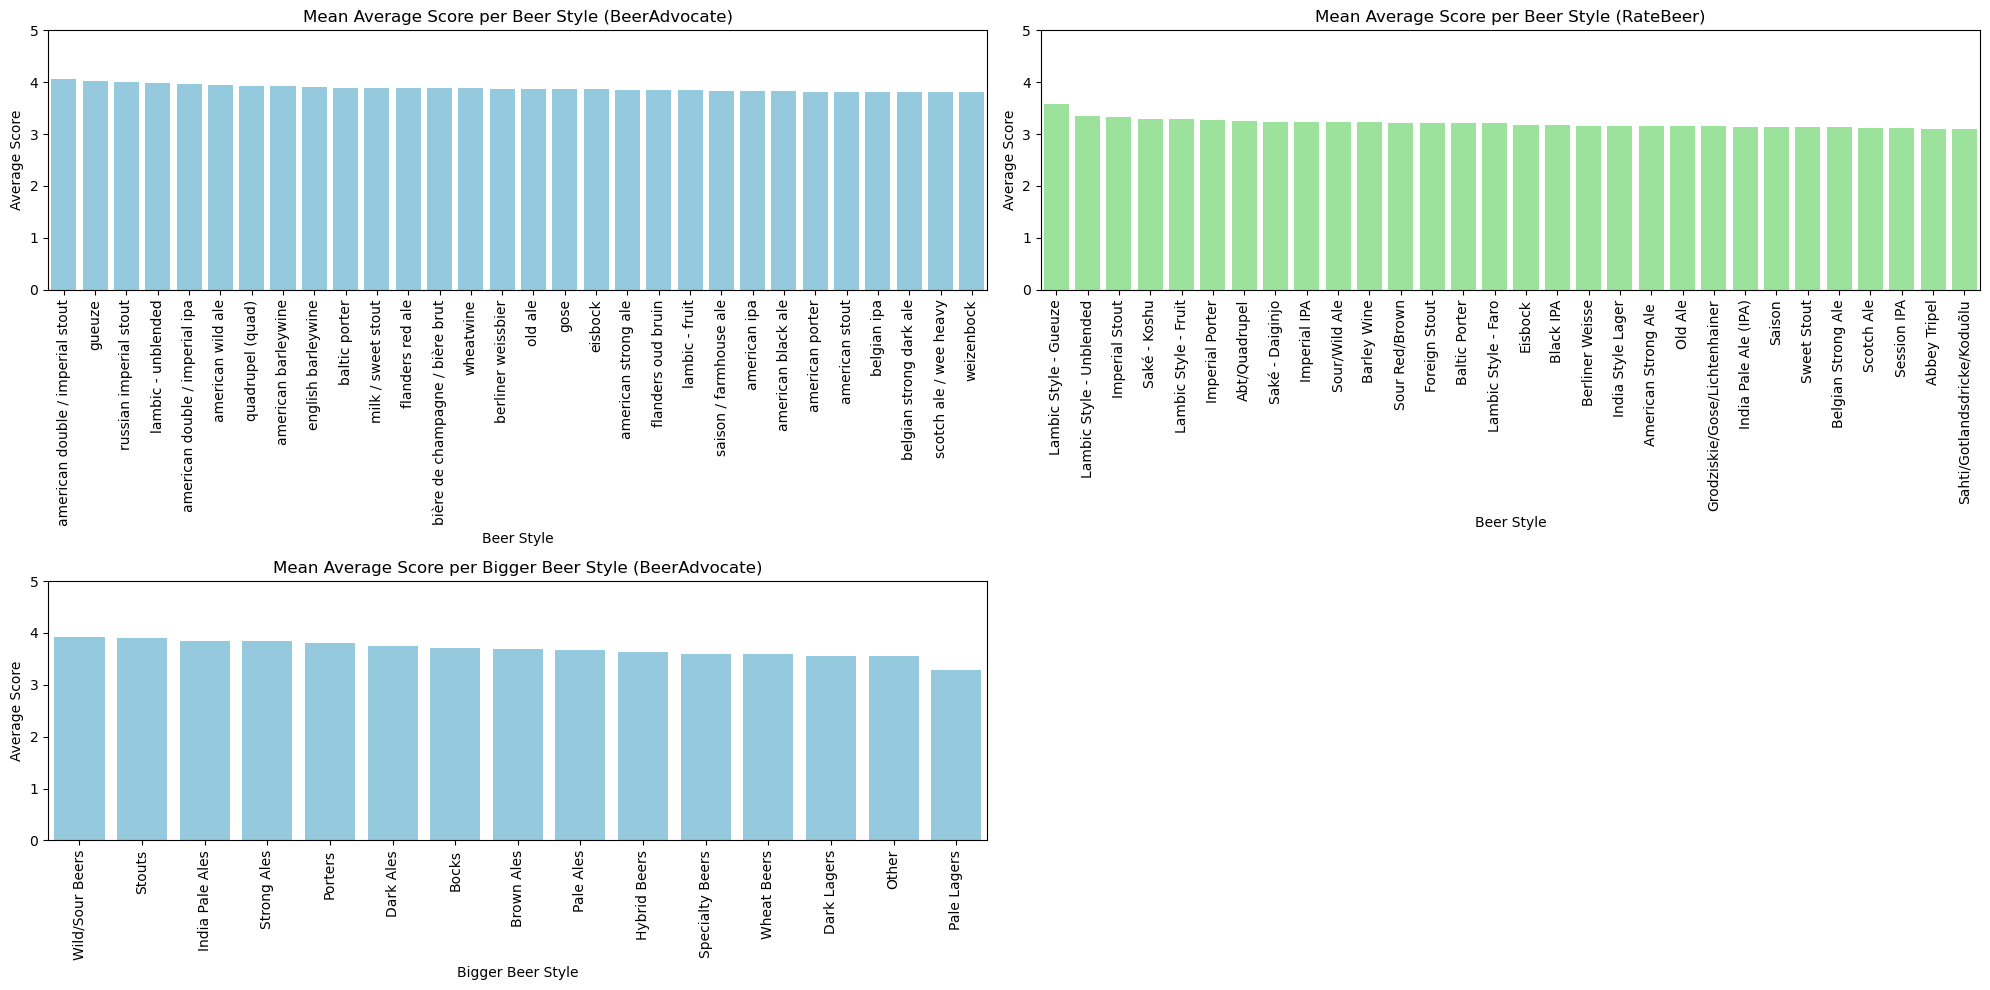

In [207]:
# Average score per style for BeerAdvocate 
ba_avg_style = beers_ba_f[['style', 'avg']].groupby('style').mean().reset_index()
ba_avg_style = ba_avg_style.sort_values(by='avg', ascending=False)
ba_avg_style = ba_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per style for RateBeer
rb_avg_style = beers_rb_f[['style', 'avg']].groupby('style').mean().reset_index()
rb_avg_style = rb_avg_style.sort_values(by='avg', ascending=False)
rb_avg_style = rb_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per bigger style for BeerAdvocate 
ba_avg_per_bigger_style = beers_ba_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
ba_avg_per_bigger_style = ba_avg_per_bigger_style.sort_values(by='avg', ascending=False)

# Average score per bigger style for RateBeer 
#rb_avg_per_bigger_style = beers_rb_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
#rb_avg_per_bigger_style = rb_avg_per_bigger_style.sort_values(by='avg', ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(2,2,1)
ax1 = sns.barplot(data=ba_avg_style, x='style', y='avg', color='skyblue')
plt.title('Mean Average Score per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for RateBeer
plt.subplot(2,2,2)
ax1 = sns.barplot(data=rb_avg_style, x='style', y='avg', color='lightgreen')
plt.title('Mean Average Score per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for BeerAdvocate
plt.subplot(2,2,3)
ax3 = sns.barplot(data=ba_avg_per_bigger_style, x='bigger_style', y='avg', color='skyblue')
plt.title('Mean Average Score per Bigger Beer Style (BeerAdvocate)')
plt.xlabel('Bigger Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

When looking at specific type of beers (not the bigger ones such as IPA, Stouts, Pale Ales, etc) we see that the average scores are pretty much the same. Even when looking at the mean average score for the bigger styles it is still the practically the same for all types of beers. Thus we can't use the average score as a metrics to predict the IPA trend. 
  

# 3. Geographical analysis of the trend 

Now that we have a little bit more insights on the beers, one might wonder what are the correlations between the variables we just studied and the location from where they come from, the breweries. One of our goal is to see where the IPA trend might come from. 

We will first look at the number of ratings across the continents and the countries. 

In [44]:
# Merge beers and brewery on brewery id
ba_beer_brewery = pd.merge(beers_ba_f, breweries_ba_f, left_on=['brewery_id'], right_on=['id'])
ba_beer_brewery = ba_beer_brewery.drop(columns=['beer_id','beer_name', 'avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

rb_beer_brewery= pd.merge(beers_rb_f, breweries_rb_f, left_on=['brewery_id'], right_on=['id'])
rb_beer_brewery = rb_beer_brewery.drop(columns=['beer_id','beer_name', 'avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

### Number of ratings per continent 

In [27]:
 def rename_country(location):
    if 'United States' in location:
        return 'United States'
    if 'U.S' in location: 
        return 'United States'
    if 'Canada' in location:
        return 'Canada'
    if 'United Kingdom' in location:
        return 'United Kingdom'
    if 'Northern Ireland' in location: 
        return 'United Kingdom'
    if 'Wales' in location: 
        return 'United Kingdom'
    if 'Scotland' in location:
        return 'United Kingdom'
    if 'England' in location:
        return 'United Kingdom'
    if 'Reunion' in location: 
        return 'France'
    if 'Fiji' in location: 
        return 'Fiji'
    if 'Utah' in location:
        return 'United States'
    if 'Trinidad & Tobago' in location:
        return 'Trinidad and Tobago'
    if 'British' in location:
        return 'United Kingdom'
    if 'Cape Verde Islands' in location:
        return 'Cabo Verde'
    if 'Saint Vincent and The Grenadines' in location:
        return 'Saint Vincent and the Grenadines'
    if 'Antigua & Barbuda' in location: 
        return 'Antigua and Barbuda'
    if 'Dem Rep of Congo' in location: 
        return 'Democratic Republic of the Congo'
    if 'Cyprus' in location: 
        return 'Cyprus'
    if 'Northern Marianas' in location: 
        return 'United States'
    if 'Tibet' in location: 
        return 'China'
    if 'South Ossetia' in location: 
        return 'Georgia'
    if 'Transdniestra' in location: 
        return 'Republic of Moldova'
    if 'Kosovo' in location: 
        return 'Serbia'
    if 'Abkhazia' in location: 
        return 'Georgia'
    if 'East Timor' in location: 
        return 'Indonesia'
    if 'Nagorno-Karabakh' in location: 
        return 'Azerbaijan'
    else:
        return location
    

def add_iso_code(location):
    try:
        country_alpha2 = py.countries.get(name=location).alpha_2
        return f'{country_alpha2}'
    except AttributeError:
        return location

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except KeyError:
        return None

In [28]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
ba_beer_brewery['location_grouped'] = ba_beer_brewery['location'].apply(rename_country)
rb_beer_brewery['location_grouped'] = rb_beer_brewery['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
ba_beer_brewery['location_with_iso'] = ba_beer_brewery['location_grouped'].apply(add_iso_code)
rb_beer_brewery['location_with_iso'] = rb_beer_brewery['location_grouped'].apply(add_iso_code)

# Convert every country into its corresponding continent into a new column 'continent'
ba_beer_brewery['continent'] = ba_beer_brewery['location_grouped'].apply(country_to_continent)
rb_beer_brewery['continent'] = rb_beer_brewery['location_grouped'].apply(country_to_continent)

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


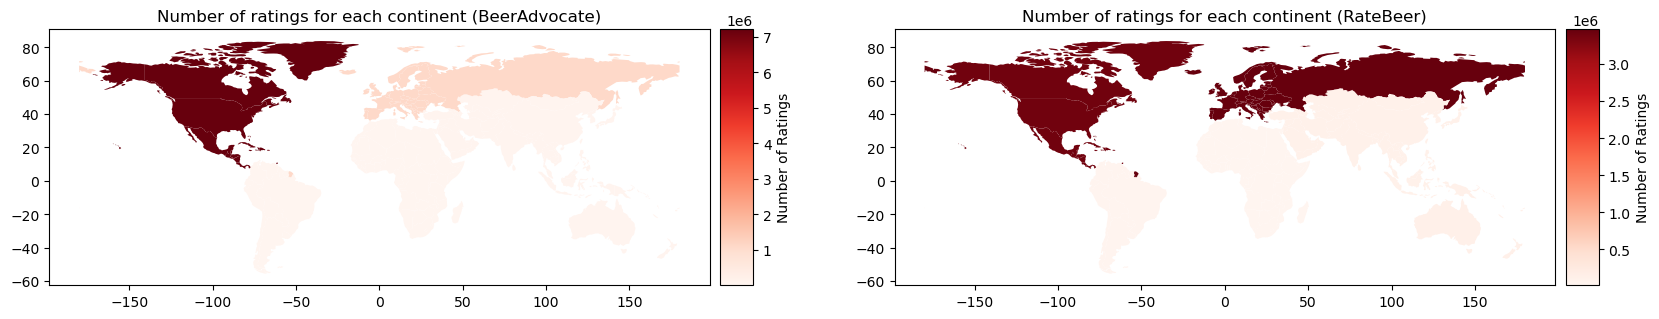

In [29]:
ba_nbr_ratings_per_continent = ba_beer_brewery.groupby('continent')['nbr_ratings'].sum()
rb_nbr_ratings_per_continent = rb_beer_brewery.groupby('continent')['nbr_ratings'].sum()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Map for BeerAdvocate
world_ba = world.merge(ba_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
world_ba.plot(column='nbr_ratings', ax=ax1, legend=True, cax=cax1, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax1.set_title('Number of ratings for each continent (BeerAdvocate)')

# Map for RateBeer
world_rb = world.merge(rb_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
world_rb.plot(column='nbr_ratings', ax=ax2, legend=True, cax=cax2, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax2.set_title('Number of ratings for each continent (RateBeer)')

plt.show()

Most ratings come from the North America and Europe. Now we will have a closer look at the countries themselves. 

### Number of ratings per country 

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

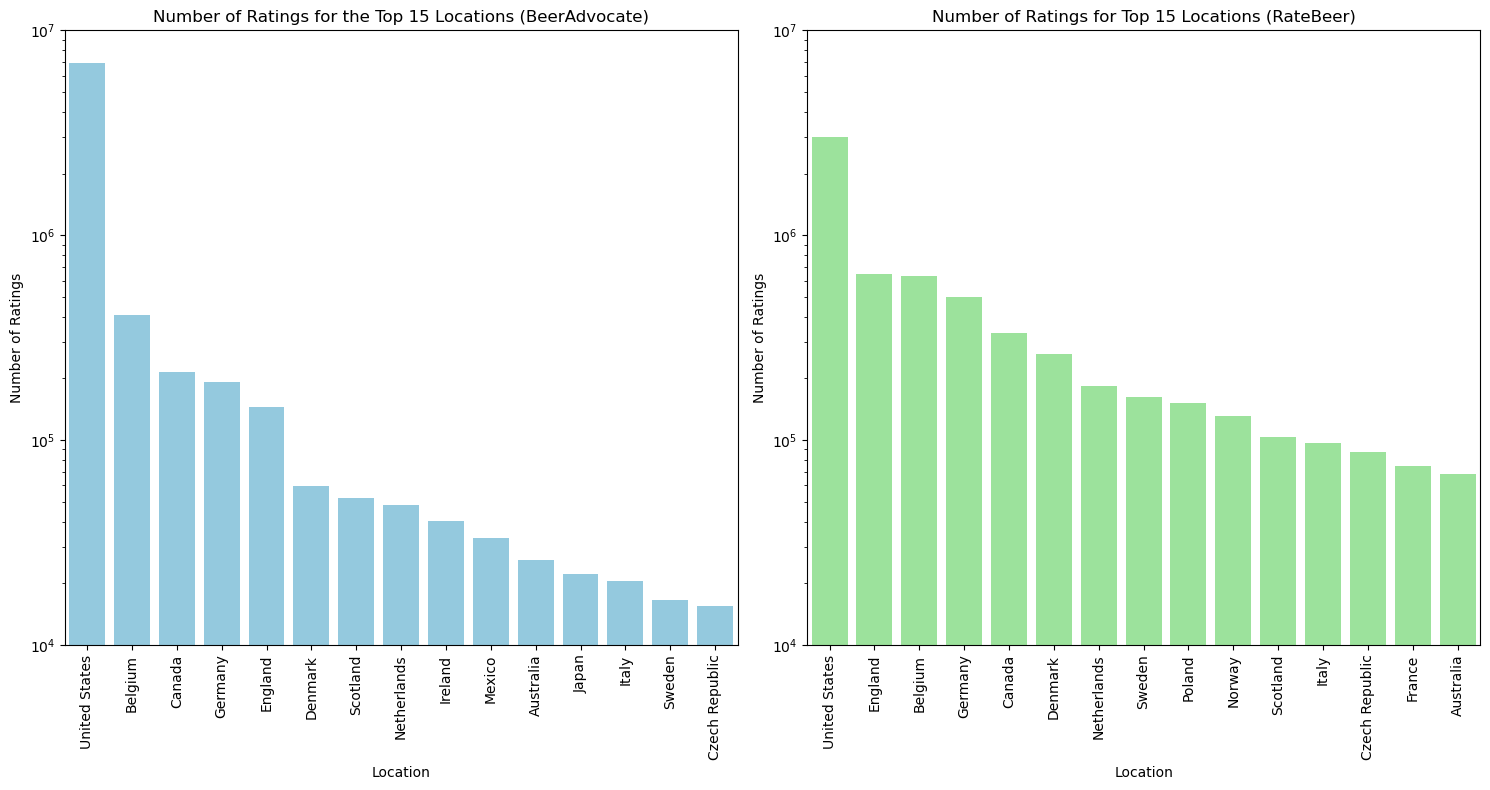

In [45]:
# Create a new column where all the states of the US are reunited 
ba_beer_brewery['countries'] = ba_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
rb_beer_brewery['countries'] = rb_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Top 15 locations with the highest number of ratings
ba_highest_rated_per_location_top15 = ba_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)
rb_highest_rated_per_location_top15 = rb_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax = sns.barplot(x=ba_highest_rated_per_location_top15.index, y=ba_highest_rated_per_location_top15.values, color='skyblue')
plt.title('Number of Ratings for the Top 15 Locations (BeerAdvocate)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_per_location_top15.index, y=rb_highest_rated_per_location_top15.values, color='lightgreen')
plt.title('Number of Ratings for Top 15 Locations (RateBeer)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show() 

As we can see the number of ratings is not equal between each countries. One may think that a country with a lot of ratings might influence others. More specifically, the United States have a lot of ratings. However, normalizing by the population of each country might be more accurate and show us better the weight a country can have on the number of ratings. Then the idea would be to select these countries and see what styles are the most rated. 
In order to analyse the IPA trend we would look at which countries have been rating IPAs the most. 

Moreover, we can observe that the numer of ratings of the United States is quite high compared to other countries. Thus, taking a closer look at the ratings per states might be useful to analyse the trend.

### Number of ratings per US states

/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_15415/2855485956.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

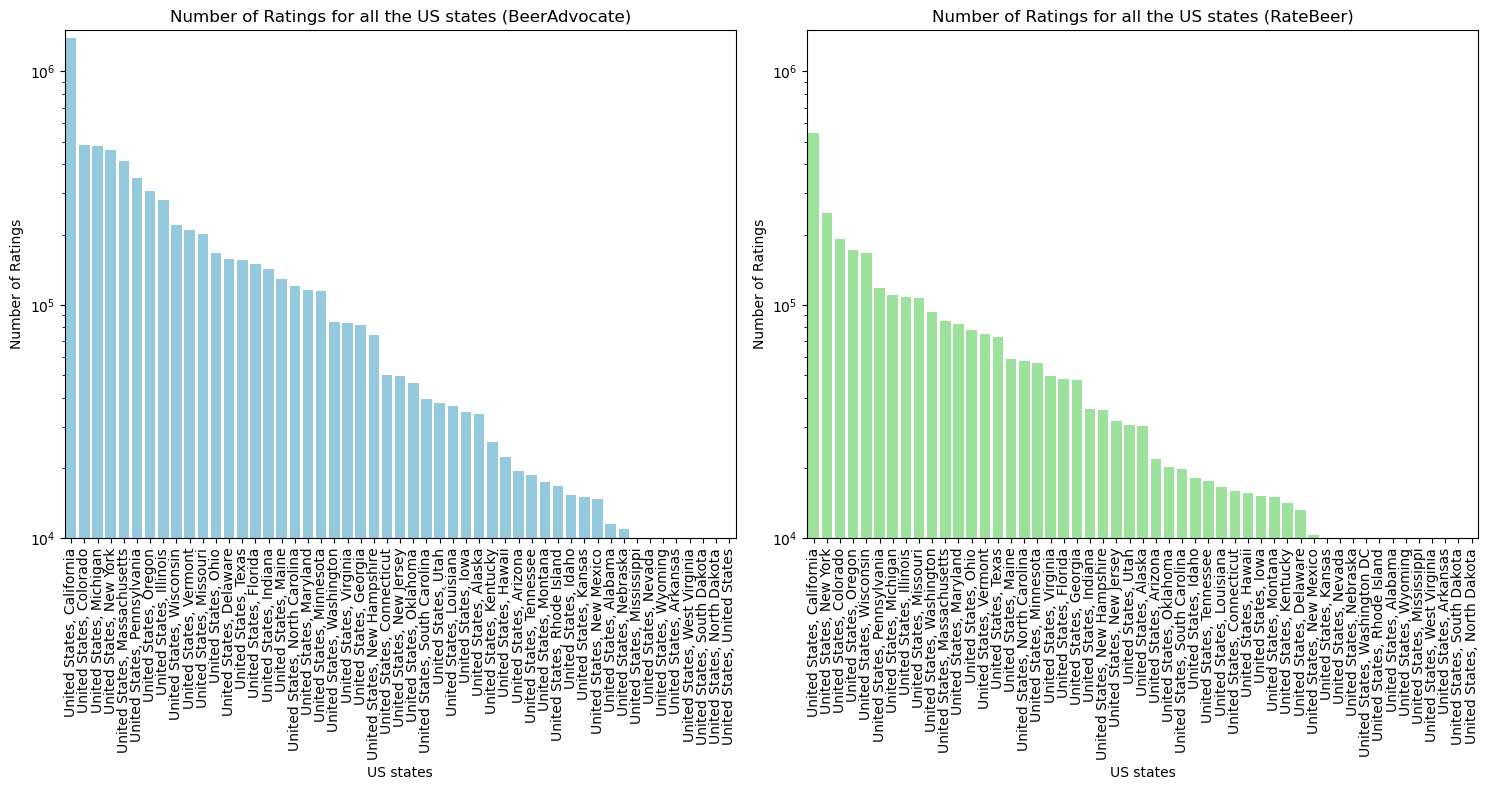

In [9]:
ba_beer_brewery_US = ba_beer_brewery.copy(deep=True)
rb_beer_brewery_US = rb_beer_brewery.copy(deep=True)

# Only keep the rows that are from the United States 
ba_beer_brewery_US = ba_beer_brewery[ba_beer_brewery['countries'] == 'United States']
rb_beer_brewery_US = rb_beer_brewery[rb_beer_brewery['countries'] == 'United States']

# Get rid of the states that aren't in the right format 
http_mask_ba = ba_beer_brewery_US['location'].str.contains('http')
http_ref_ba = ba_beer_brewery_US['location'].str.contains('href')
http_mask_rb = rb_beer_brewery_US['location'].str.contains('http')
http_ref_rb = rb_beer_brewery_US['location'].str.contains('href')

# Keep rows where 'location' does not contain "http" or "href"
ba_beer_brewery_US = ba_beer_brewery_US[~http_mask_ba]
ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]
rb_beer_brewery_US = rb_beer_brewery_US[~http_mask_rb]
rb_beer_brewery_US = rb_beer_brewery_US[~http_ref_rb]

ba_highest_rated_states = ba_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)
rb_highest_rated_states = rb_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax1 = sns.barplot(x=ba_highest_rated_states.index, y=ba_highest_rated_states.values, color='skyblue')
plt.title('Number of Ratings for all the US states (BeerAdvocate)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_states.index, y=rb_highest_rated_states.values, color='lightgreen')
plt.title('Number of Ratings for all the US states (RateBeer)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

plt.tight_layout()
plt.show() 

There is a significant difference for the number of ratings between the states. This is helpful to analyse the pattern of the trend within the US giving us an even closer look at the trend. 

### Breweries 
Studying variables such as the number of breweries and the diversity of brewed beers could show if the trend came from microbreweries or on the countrary from big breweries. 

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_15415/2475312092.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10000)
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_catego

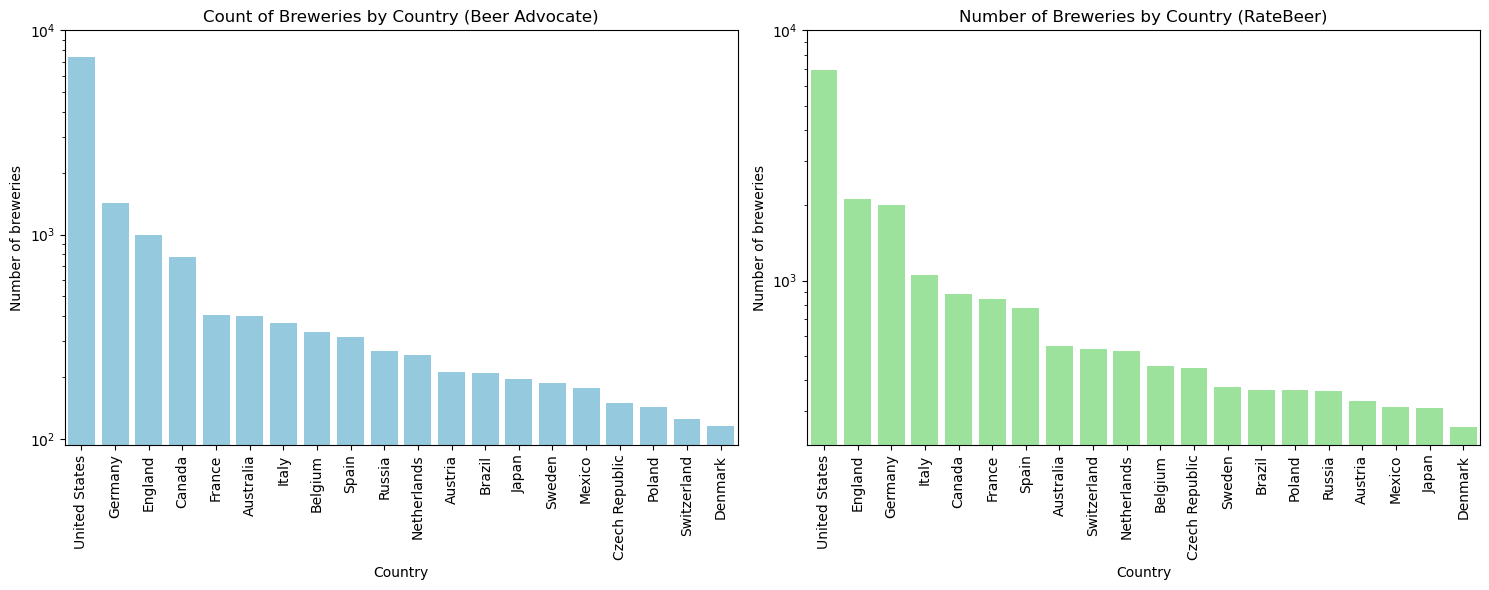

In [53]:
breweries_ba_f['countries'] = breweries_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)
breweries_rb_f['countries'] = breweries_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)

# Top 15 countries with the most breweries on RateBeer
nbr_breweries_rb = breweries_rb_f['countries'].value_counts().nlargest(20)
nbr_breweries_ba = breweries_ba_f['countries'].value_counts().nlargest(20)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=breweries_ba_f, x='countries', order=nbr_breweries_ba.index, color='skyblue')
plt.title('Count of Breweries by Country (Beer Advocate)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=breweries_rb_f, x='countries', order=nbr_breweries_rb.index, color='lightgreen')
plt.title('Number of Breweries by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

plt.tight_layout()
plt.show()

Germany and England are definitely up there regarding the number of breweries. However, we can see that the United States are the country with the highest number of breweries. 

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_15415/755601258.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000000)
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

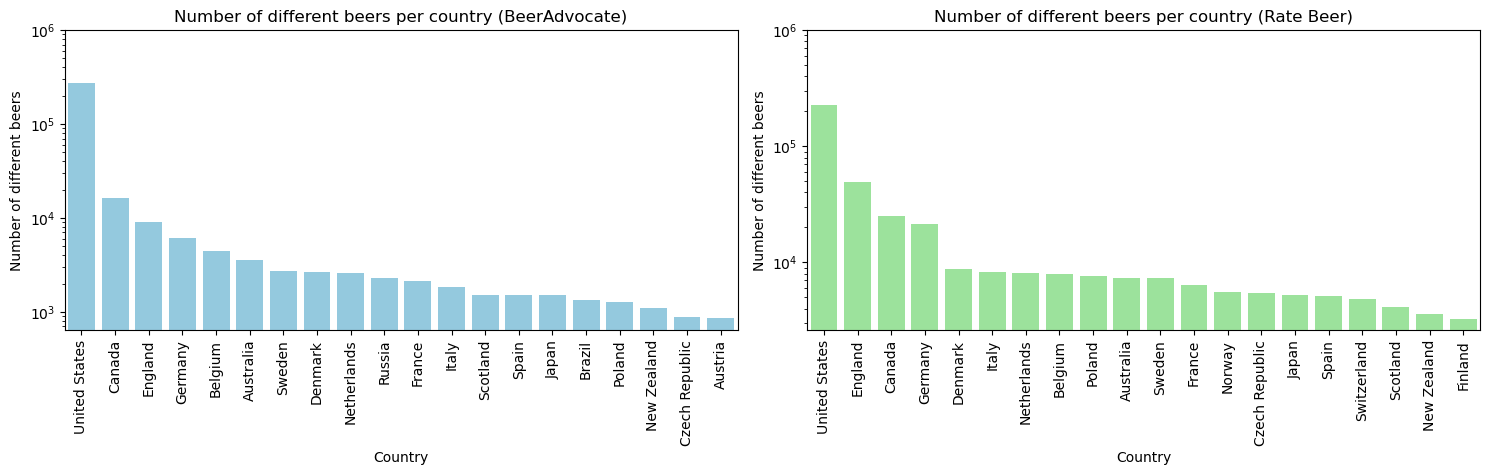

In [60]:
# Number of different beers per location 
rb_nbr_beer_location = breweries_rb_f.groupby('countries')['nbr_beers'].sum().nlargest(20)
ba_nbr_beer_location = breweries_ba_f.groupby('countries')['nbr_beers'].sum().nlargest(20)

plt.figure(figsize=(15, 8))  

plt.subplot(2,2,1)
ax1 = sns.barplot(x=ba_nbr_beer_location.index, y=ba_nbr_beer_location.values, color='skyblue')
plt.title('Number of different beers per country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.subplot(2,2,2)
ax2 = sns.barplot(x=rb_nbr_beer_location.index, y=rb_nbr_beer_location.values, color='lightgreen')
plt.title('Number of different beers per country (Rate Beer)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.tight_layout()
plt.show()

The United Stated are the country that have the highest number of different brewed beers. However, we can see that even for smaller countries such as Germany and England they are still in the top 5. For further analysis we could study the weight that each country has in the production of beers. Then we will be able to also analyse the production of each style of beer for every country. More specifically we could see the country which produces the highest number of IPAs. 
Furthermore, we could normalize the number of beers by the population of each country and see which country produces the highest number of IPAs per habitants. This could help us identify countries where IPAs is trendy. 

# 4. Social analysis of the trend 

We will now focus on the type of users that rate the beers on the websites. Regarding the users we will look at their origin, the date in which they entered the websites, and the styles of beer they review. One important factor of a trend is the time so will mostly study these in a chronological way.  
One goal here would be to identify fan clubs which could be another metric to identify the trend of IPAs

### Number of users per country

/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_15415/350638278.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000000)
/Users/margot/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

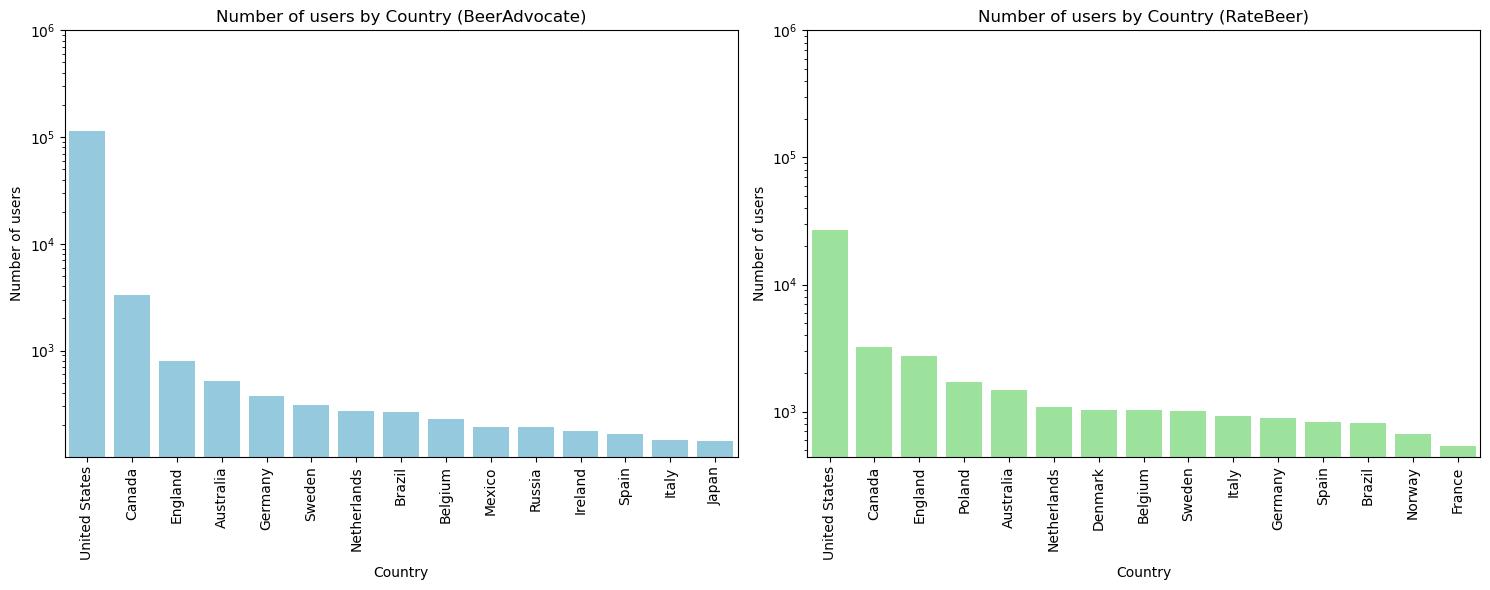

In [82]:
# Group variations of 'United States' in the 'country' column
users_ba['countries'] = users_ba['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
users_rb['countries'] = users_rb['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Get the 15 most represented countries
nbr_users_ba = users_ba['countries'].value_counts().nlargest(15)
nbr_users_rb = users_rb['countries'].value_counts().nlargest(15)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=users_ba, x='countries', order=nbr_users_ba.index, color='skyblue')
plt.title('Number of users by Country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=users_rb, x='countries', order=nbr_users_rb.index, color='lightgreen')
plt.title('Number of users by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

plt.tight_layout()
plt.show()

Most of the users are americans.

# Study of Reviews.csv data from BeerAdvocate and Ratebeer

## Estimated number of languages in reviews.csv

### For BeerAdvocate 

In [12]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_ba}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector = pd.concat(lang_vectors, ignore_index=True)

# Display the result
print(result_lang_vector.unique())


['ENGLISH' 'FRENCH' 'FINNISH' 'PORTUGUESE' 'SPANISH' 'ITALIAN' 'DUTCH'
 'Unknown' 'DANISH' 'CZECH' 'GERMAN' 'CATALAN' 'CROATIAN' 'RUSSIAN'
 'TURKISH' 'SWEDISH' 'ESTONIAN' 'AFRIKAANS' 'NaN' 'NORWEGIAN' 'Chinese']


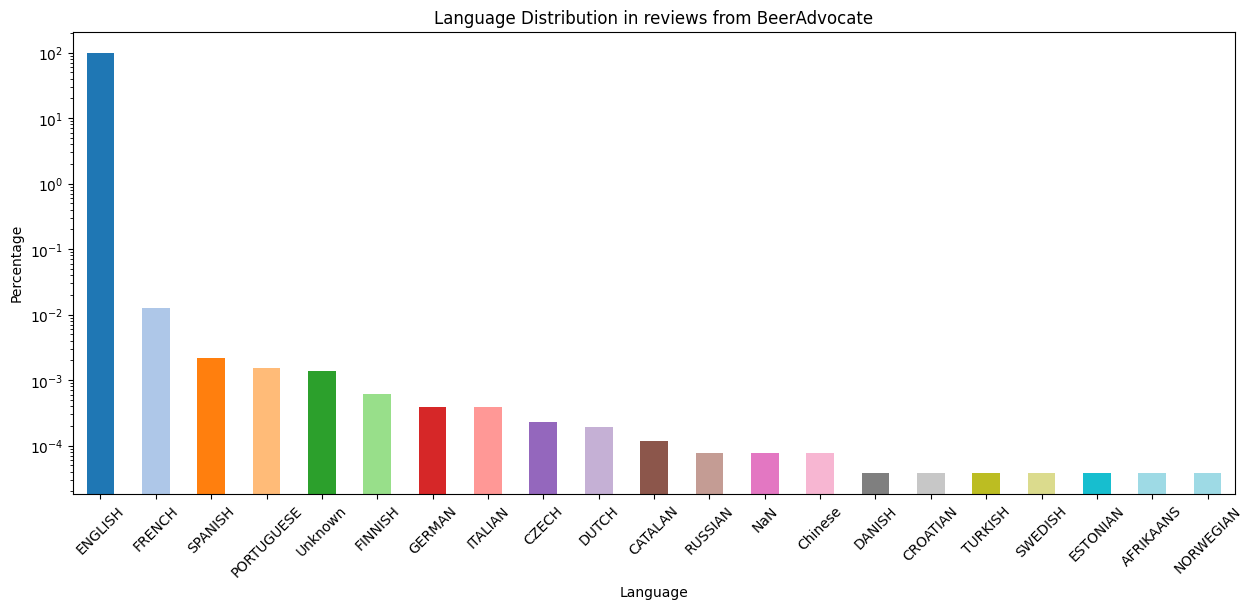

Percentage of unrecognized language: 0.0014%
Percentage of empty comments: 0.00008%


In [16]:
# Plot percentage

# Calculate the counts of each language
lang_counts = result_lang_vector.value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color=plt.cm.tab20(np.linspace(0, 1, len(lang_percentages))), logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages.get('NaN', 0):.5f}%")


Unsurprisingly, over 99% of comments are written in English, 0.0014% of comments are in a language not recognized by cld2 and a very small number are empty.
We can have a quick look at the distribution of languages if we remove users from USA knowing (from the previous analysis) that they are the most numerous users of this site.

In [17]:
# Start by loading reviews.csv from BeerAdvocate
reviews_ba_f = pd.read_csv(f'{path_ba}/reviews.csv', usecols=['user_name','text'])

# Use column user_name and location only
users_ba_f= users_ba[["user_name","location"]].copy(deep=True)

# Remove states info, keep only Country
users_ba_f['location'] = users_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [18]:
# Merge on User_name and remove United States
reviews_ba_f = reviews_ba_f.merge(users_ba_f, on='user_name', how='left')
reviews_ba_f = reviews_ba_f[reviews_ba_f['location'] != 'United States']

In [19]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_ba_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_ba_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_ba_f['lang'].unique())

['ENGLISH' 'FRENCH' 'FINNISH' 'PORTUGUESE' 'SPANISH' 'ITALIAN' 'DUTCH'
 'Unknown' 'CZECH' 'GERMAN' 'CATALAN' 'CROATIAN' 'RUSSIAN' 'TURKISH'
 'SWEDISH' 'ESTONIAN' 'NORWEGIAN' 'Chinese']


[]

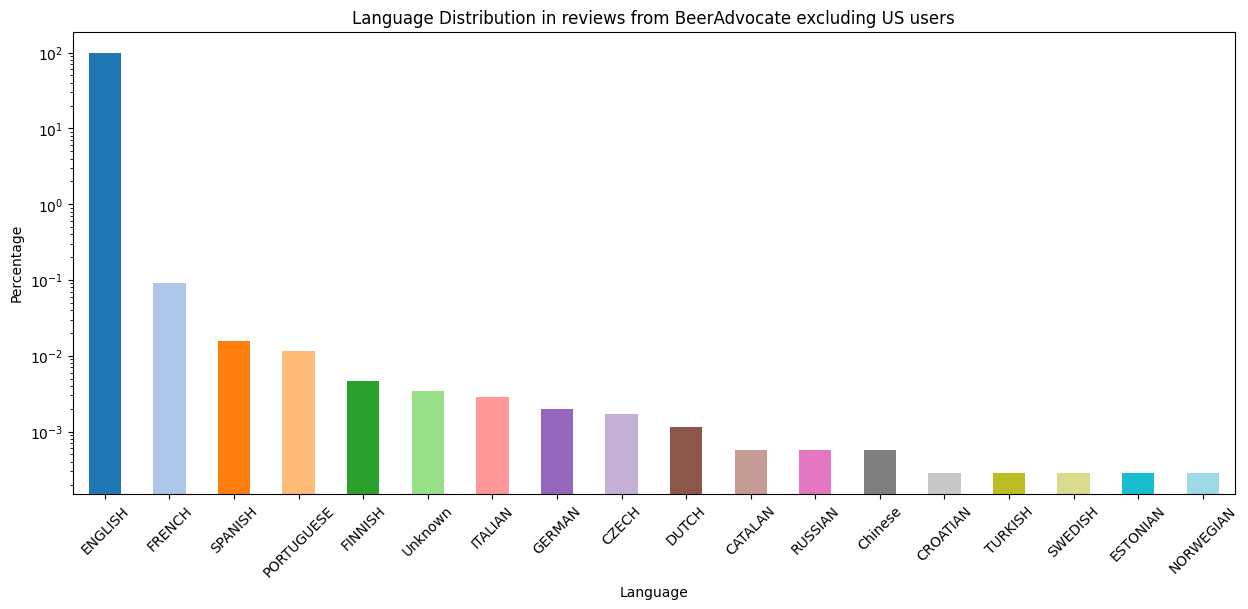

In [20]:
# Calculate the counts of each language
lang_counts = reviews_ba_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color=plt.cm.tab20(np.linspace(0, 1, len(lang_percentages))), logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.plot()

Surprisingly (or not), even if you remove users from the USA, the most widely spoken language is still English.

### For RateBeer

In [31]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors_rb = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_rb}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors_rb.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector_rb = pd.concat(lang_vectors_rb, ignore_index=True)

# Display the result
print(result_lang_vector_rb.unique())

['POLISH' 'SPANISH' 'ENGLISH' 'Unknown' 'GERMAN' 'SWEDISH' 'NORWEGIAN'
 'ITALIAN' 'DANISH' 'FINNISH' 'FRENCH' 'RUSSIAN' 'HUNGARIAN' 'CROATIAN'
 'DUTCH' 'WARAY_PHILIPPINES' 'IRISH' 'CATALAN' 'Korean' 'NaN' 'PORTUGUESE'
 'Japanese' 'Chinese' 'SLOVAK' 'CZECH' 'LITHUANIAN' 'ROMANIAN'
 'NORWEGIAN_N' 'UKRAINIAN' 'TURKISH' 'BOSNIAN' 'SERBIAN' 'ESTONIAN'
 'BULGARIAN' 'ICELANDIC' 'LATIN' 'LATVIAN' 'INDONESIAN' 'NAURU' 'CORSICAN'
 'AFRIKAANS' 'FAROESE' 'THAI' 'ChineseT' 'YORUBA' 'GREEK' 'GALICIAN'
 'INTERLINGUA' 'LUXEMBOURGISH' 'MACEDONIAN' 'VOLAPUK' 'SLOVENIAN' 'SCOTS'
 'SAMOAN' 'RHAETO_ROMANCE' 'MALTESE' 'WELSH' 'BASQUE' 'SWAHILI' 'OCCITAN'
 'KYRGYZ' 'GUARANI' 'MALAY' 'ZULU' 'X_PIG_LATIN' 'HAITIAN_CREOLE' 'ARABIC'
 'JAVANESE']


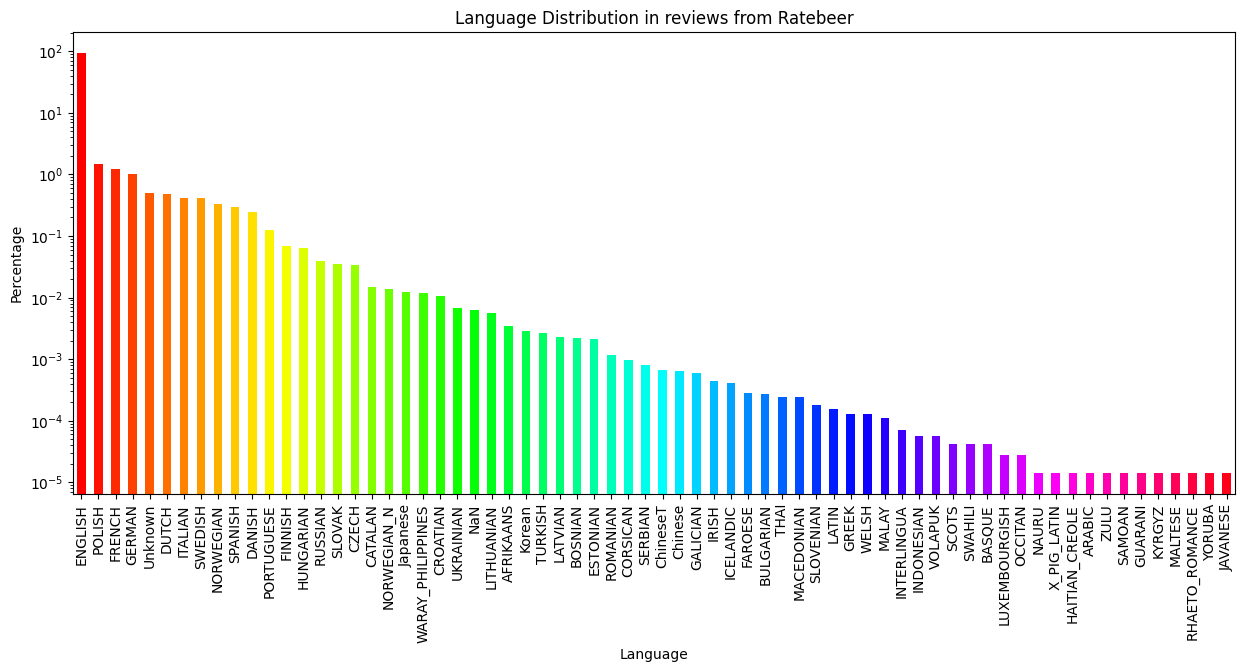

Percentage of unrecognized language: 0.5077%
Percentage of empty comments: 0.0063%


In [32]:
# Plot ratio

# Calculate the counts of each language
lang_counts_rb = result_lang_vector_rb.value_counts()

# Calculate the ratio of each language
lang_percentages_rb = lang_counts_rb / lang_counts_rb.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages_rb.plot(kind='bar', color=plt.cm.hsv(np.linspace(0, 1, len(lang_percentages_rb))),logy=True)
plt.title('Language Distribution in reviews from Ratebeer')
plt.xlabel('Language')
plt.ylabel('Percentage')

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages_rb.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages_rb.get('NaN', 0):.4f}%")

Once again, English is by far the dominant language. However, there are many more languages than in BeerAdvocate.
There are also more empty comments and unrecognized languages. This is due to the number of comments, as RateBeer's dataset contains 7 122 074 comments compared to the 2 589 586 comments in BeerAdvocate's dataset.

As before, let's look at the distribution of languages without users living in the USA. 

In [33]:
# Start by loading reviews.csv from RateBeer
reviews_rb_f = pd.read_csv(f'{path_rb}/reviews.csv', usecols=['user_name','text'])

users_rb_f= users_rb[["user_name","location"]].copy(deep=True)
users_rb_f['location'] = users_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [34]:
# Merge on User_name and remove United States
reviews_rb_f = reviews_rb_f.merge(users_rb_f, on='user_name', how='left')
reviews_rb_f = reviews_rb_f[reviews_rb_f['location'] != 'United States']

In [35]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_rb_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_rb_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_rb_f['lang'].unique())

['POLISH' 'SPANISH' 'ENGLISH' 'Unknown' 'GERMAN' 'SWEDISH' 'NORWEGIAN'
 'ITALIAN' 'DANISH' 'FINNISH' 'FRENCH' 'RUSSIAN' 'HUNGARIAN' 'CROATIAN'
 'DUTCH' 'WARAY_PHILIPPINES' 'IRISH' 'CATALAN' 'Korean' 'NaN' 'PORTUGUESE'
 'Chinese' 'SLOVAK' 'CZECH' 'LITHUANIAN' 'ROMANIAN' 'NORWEGIAN_N'
 'UKRAINIAN' 'TURKISH' 'BOSNIAN' 'SERBIAN' 'ESTONIAN' 'BULGARIAN'
 'ICELANDIC' 'LATVIAN' 'INDONESIAN' 'LATIN' 'NAURU' 'CORSICAN' 'AFRIKAANS'
 'Japanese' 'FAROESE' 'THAI' 'ChineseT' 'YORUBA' 'GREEK' 'GALICIAN'
 'INTERLINGUA' 'LUXEMBOURGISH' 'MACEDONIAN' 'VOLAPUK' 'SLOVENIAN' 'SCOTS'
 'SAMOAN' 'RHAETO_ROMANCE' 'MALTESE' 'WELSH' 'BASQUE' 'SWAHILI' 'OCCITAN'
 'KYRGYZ' 'GUARANI' 'MALAY']


[]

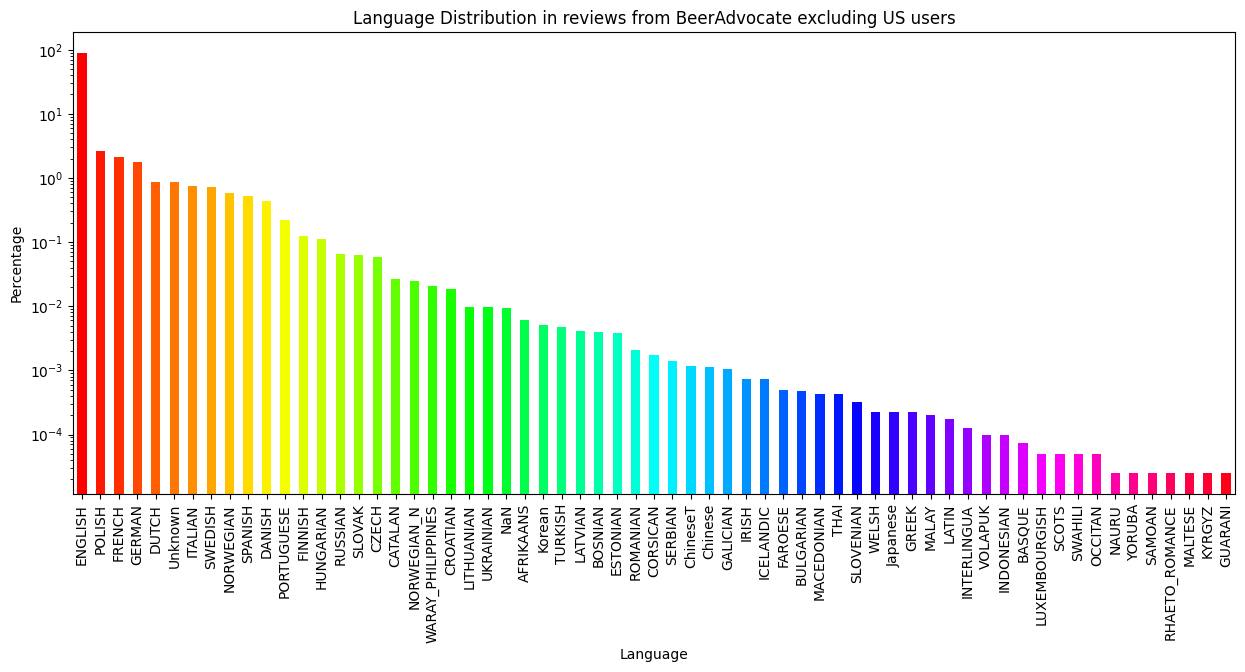

In [36]:
# Calculate the counts of each language
lang_counts = reviews_rb_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color=plt.cm.hsv(np.linspace(0, 1, len(lang_percentages))), logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.plot()

## Ratings from BeerAdvocate & RateBeer

Why Ratings instead of Reviews? Simply because Reviews is a subset of Ratings. So by analyzing the former, we analyze the latter.

### Load and merge

In [4]:
# Start by loading reviews.csv from BeerAdvocate
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

users_ba_f= users_ba.copy(deep=True)

# Load reviews.csv from RateBeer
ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')

users_rb_f= users_rb.copy(deep=True)

In [5]:
# Modify date information 
# Convert Unix timestamps to 'YYYY-MM-DD' format and handle non-timestamp values
def convert_to_date(series):
    try:
        return pd.to_datetime(series, unit='s').dt.strftime('%Y-%m-%d')
    except (TypeError, ValueError):
        return series

In [13]:
# Merge users from BeerAdvocate in rating file with their countries info

ratings_ba_f = ratings_ba_f.merge(users_ba_f, on='user_name', how='left')
ratings_ba_f['location'] = ratings_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

ratings_ba_f['date'] = convert_to_date(ratings_ba_f['date'])
ratings_ba_f['joined'] = convert_to_date(ratings_ba_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_ba_f['date'] = pd.to_datetime(ratings_ba_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_ba_f['joined'] = pd.to_datetime(ratings_ba_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [ ]:
ratings_ba_f.isna().sum()

beer_name             0
beer_id               0
brewery_name          0
brewery_id            0
style                 0
abv              171305
date                  0
user_name            31
user_id_x             0
appearance      3623357
aroma           3623357
palate          3623357
taste           3623357
overall         3623357
rating                0
text            5677323
review                0
nbr_ratings           0
nbr_reviews           0
user_id_y             0
joined           347909
location         500278
dtype: int64

We identify more than 5,677,323 lines without comments.

In [ ]:
# Delete duplicate users to get other statistics 
ratings_ba_f.drop_duplicates(subset='user_name').isna().sum()


beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv              1601
date                0
user_name           1
user_id_x           0
appearance      71136
aroma           71136
palate          71136
taste           71136
overall         71136
rating              0
text            98502
review              0
nbr_ratings         0
nbr_reviews         0
user_id_y           0
joined           2652
location        31279
dtype: int64

We note the presence of 2,652 users whose date of joining BeerAdvocate is unknown. And 31,279 out of 153,705 did not specify their location. We can also see that the same users tend not to fill in all the data (abv, text, appearance, aroma, palate, taste, overall) as the number of Nan decreases when usernames duplicates are removed (this means we keep only one comment per user). 

We may have to remove these users, who provide little information.

In [6]:
# Merge users from RateBeer in ratings file with their countries info

ratings_rb_f = ratings_rb_f.merge(users_rb_f, on='user_name', how='left')
ratings_rb_f['location'] = ratings_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)


ratings_rb_f['date'] = convert_to_date(ratings_rb_f['date'])
ratings_rb_f['joined'] = convert_to_date(ratings_rb_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_rb_f['date'] = pd.to_datetime(ratings_rb_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_rb_f['joined'] = pd.to_datetime(ratings_rb_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [8]:
ratings_rb_f.isna().sum()

beer_name            0
beer_id              0
brewery_name         0
brewery_id           0
style                0
abv             174984
date                 0
user_name            0
user_id_x            0
appearance           0
aroma                0
palate               0
taste                0
overall              0
rating               0
text               448
nbr_ratings          0
user_id_y            0
joined            2627
location        203679
dtype: int64

We have no missing values, except for the alcohol content of the beer and the text, but the latter is very low and the degree of alcohol is of no interest to us in our study.
To study nbr_ratings, joined and location we need to remove duplicates. 


In [9]:
# Delete duplicate users to get other statistics 
ratings_rb_f.drop_duplicates(subset='user_name').isna().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv               974
date                0
user_name           0
user_id_x           0
appearance          0
aroma               0
palate              0
taste               0
overall             0
rating              0
text               27
nbr_ratings         0
user_id_y           0
joined             30
location        19579
dtype: int64

19,579 users out of 70,175 did not specify their location. Even if this number is high, it may represent users who don't post regularly (below 3 comments). This should not be a problem for the rest of our project.
For the account creation date, the number of missing values is minimal.

In [11]:
# Verify that it is the case 
ratings_rb_f[ratings_rb_f['nbr_ratings'] >= 3].drop_duplicates(subset='user_name').isna().sum()

beer_name          0
beer_id            0
brewery_name       0
brewery_id         0
style              0
abv              311
date               0
user_name          0
user_id_x          0
appearance         0
aroma              0
palate             0
taste              0
overall            0
rating             0
text              11
nbr_ratings        0
user_id_y          0
joined            18
location        7074
dtype: int64

We can see straight away that the number of users without a location has fallen sharply by selecting users with at least 3 reviews. 

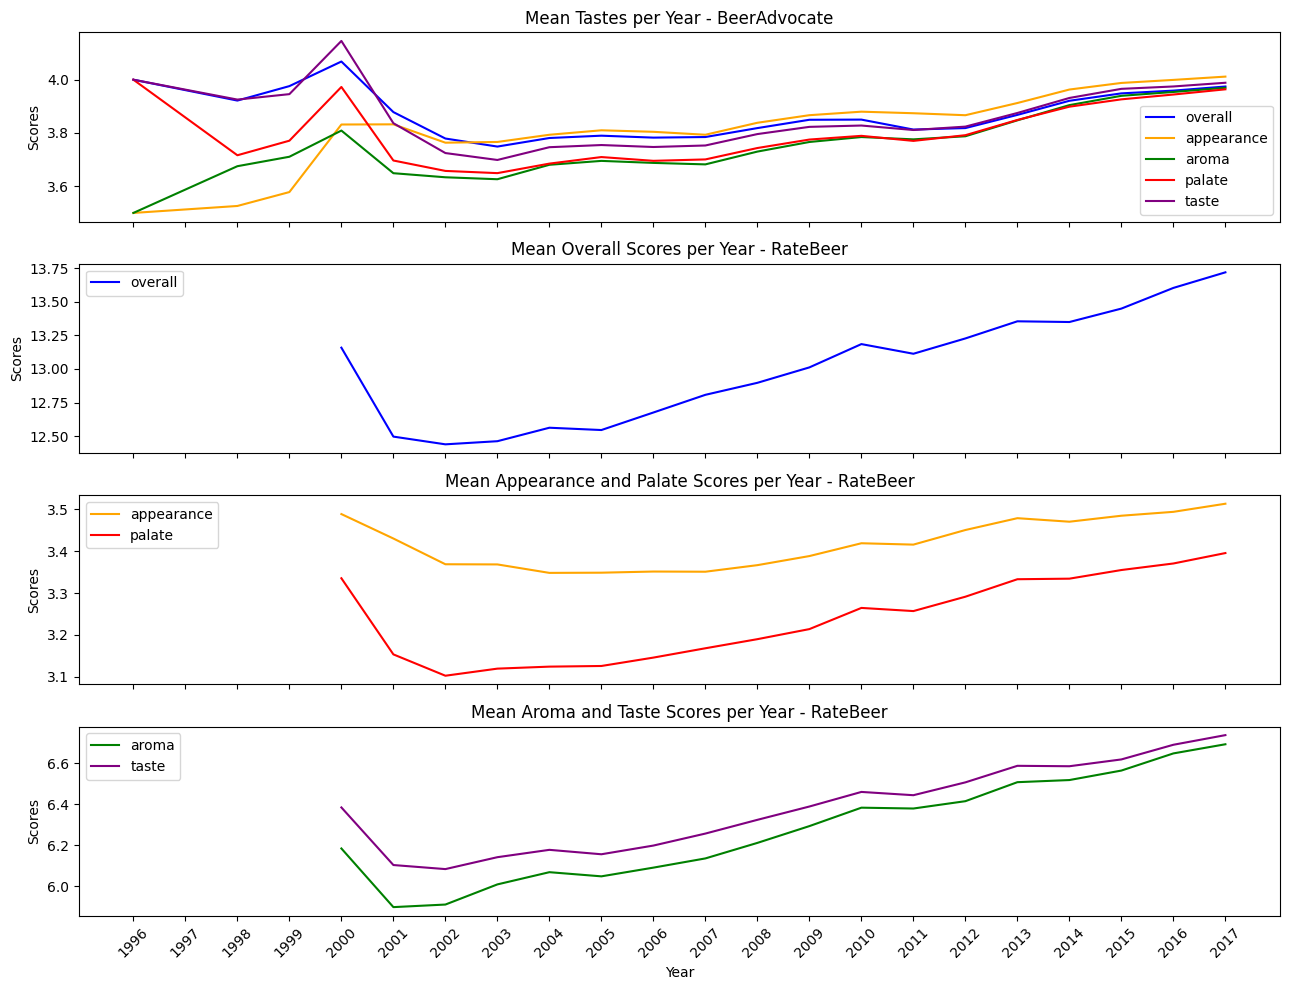

In [49]:
#Evolution of mean tastes along the years for RateBeer
summary_df_rb = ratings_rb_f.groupby('date').agg({'overall': 'mean', 'appearance': 'mean', 'aroma': 'mean', 'palate': 'mean', 'taste': 'mean'}).reset_index()


#Evolution of mean tastes along the years for BeerAdvocate
summary_df_ba = ratings_ba_f.groupby('date').agg({'overall': 'mean', 'appearance': 'mean', 'aroma': 'mean', 'palate': 'mean', 'taste': 'mean'}).reset_index()


# Create a figure with two subplots
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

# Plot for BeerAdvocate
axs[0].plot(summary_df_ba['date'], summary_df_ba['overall'], label='overall',color='blue')
axs[0].plot(summary_df_ba['date'], summary_df_ba['appearance'], label='appearance',color='orange')
axs[0].plot(summary_df_ba['date'], summary_df_ba['aroma'], label='aroma',color='green')
axs[0].plot(summary_df_ba['date'], summary_df_ba['palate'], label='palate',color='red')
axs[0].plot(summary_df_ba['date'], summary_df_ba['taste'], label='taste',color='purple')
axs[0].set_ylabel('Scores')
axs[0].set_title('Mean Tastes per Year - BeerAdvocate')
axs[0].legend()

# Plot for RateBeer - Subplot 1
axs[1].plot(summary_df_rb['date'], summary_df_rb['overall'], label='overall',color='blue')
axs[1].set_ylabel('Scores')
axs[1].set_title('Mean Overall Scores per Year - RateBeer')
axs[1].legend()


# Plot for 'appearance'
axs[2].plot(summary_df_rb['date'], summary_df_rb['appearance'], label='appearance',color='orange')
axs[2].plot(summary_df_rb['date'], summary_df_rb['palate'], label='palate',color='red')
axs[2].set_ylabel('Scores')
axs[2].set_title('Mean Appearance and Palate Scores per Year - RateBeer')
axs[2].legend()


# Plot for 'aroma', 'taste'
axs[3].plot(summary_df_rb['date'], summary_df_rb['aroma'], label='aroma',color='green')
axs[3].plot(summary_df_rb['date'], summary_df_rb['taste'], label='taste',color='purple')
axs[3].set_xlabel('Year')
axs[3].set_ylabel('Scores')
axs[3].set_title('Mean Aroma and Taste Scores per Year - RateBeer')
axs[3].legend()
axs[3].set_xticks(np.arange(1996, 2018, step=1))
axs[3].tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


It can be seen that, on average, scores tend to increase on both sites. We have comments from 1996 users on BeerAdvocate. Let's see how many there are:

### Number of comments per years for both datasets:

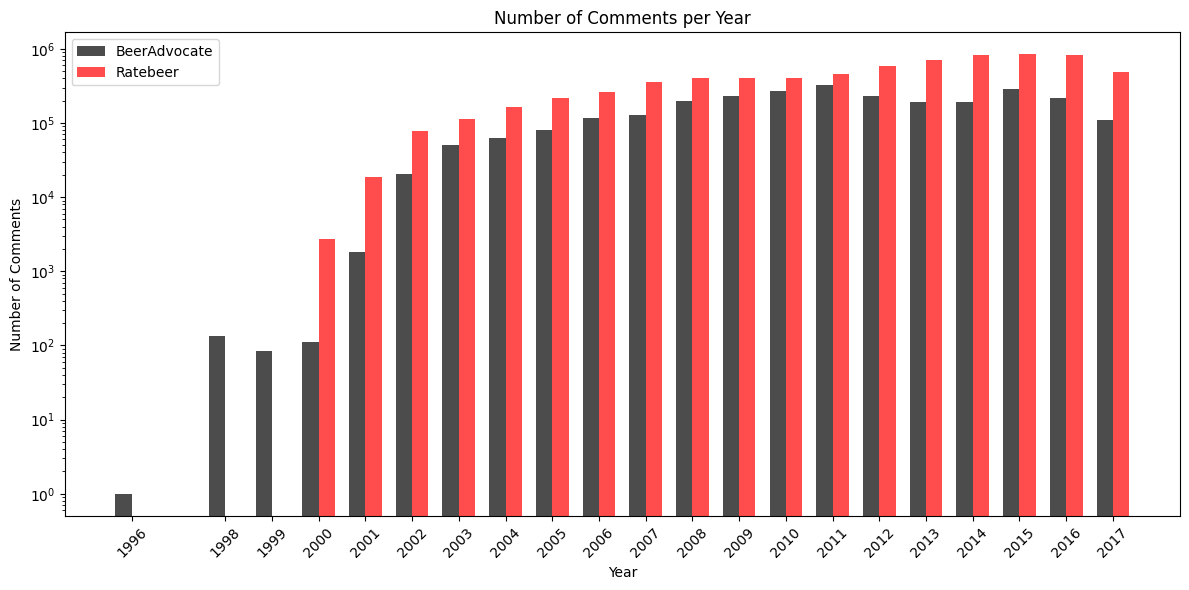

In [50]:
# For BeerAdvocate
comments_per_year_ba = ratings_ba_f.groupby('date')["text"].count().reset_index()
comments_per_year_ba.columns = ['Year', 'nb of comments']

# For Ratebeer
comments_per_year_rb = ratings_rb_f.groupby('date')["text"].count().reset_index()
comments_per_year_rb.columns = ['Year', 'nb of comments']

# Add values from 1996 to 1999
missing_years = pd.DataFrame({'Year': [1996, 1998, 1999], 'nb of comments': [0, 0, 0]})
comments_per_year_rb = pd.concat([missing_years, comments_per_year_rb]).sort_values('Year')

years = np.array([year for year in range(1996, 2018) if year != 1997])

bar_width = 0.35  # Largeur des barres

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, comments_per_year_ba['nb of comments'], bar_width, color='black', alpha=0.7, label='BeerAdvocate')
plt.bar(years + bar_width/2, comments_per_year_rb['nb of comments'], bar_width, color='red', alpha=0.7, label='Ratebeer')

plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.yscale('log')
plt.title('Number of Comments per Year')
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

There was only one comment in 1996 and 0 in 1997. With further verification (not detailed here) we were able to see that it was the founder of BeerAdvocate (Todd Alström) who wrote this comment in 1996.

In any case, what we can see here is that to try and identify a trend in beer consumption, we can't base ourselves on years too close to creation. Instead, look for years when the number of comments has exceeded 10^4. So around 2002. 

### Number of new users per years for both datasets:

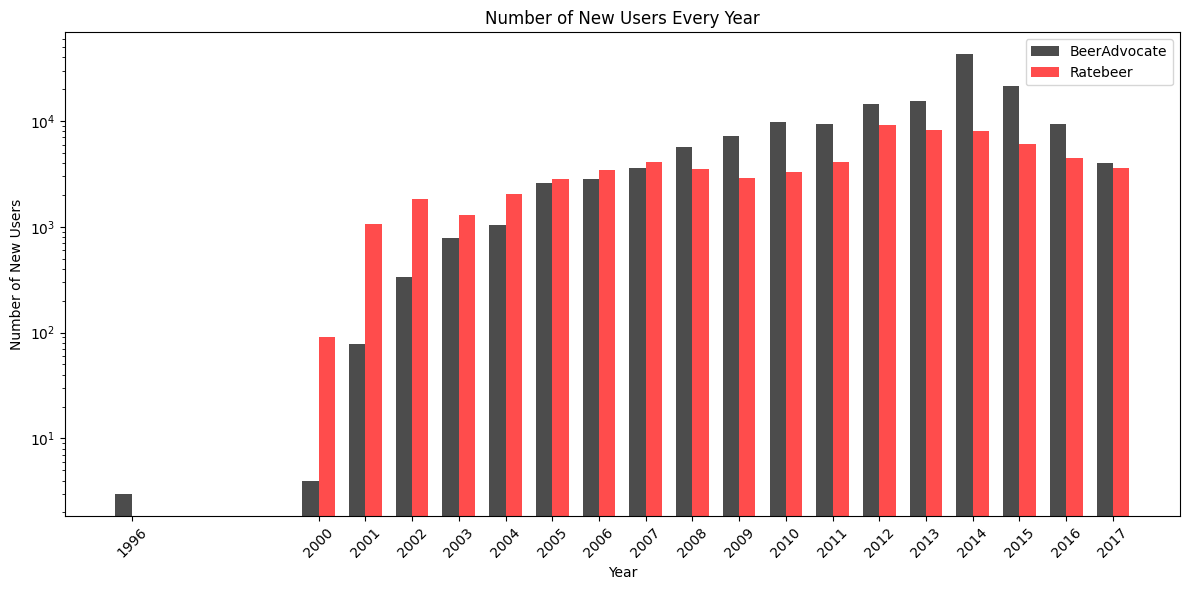

In [51]:
# Pour le premier DataFrame ratings_rb_f
new_users_per_year_rb = ratings_rb_f.groupby('joined')['user_id_y'].nunique().reset_index()

# Pour le deuxième DataFrame ratings_ba_f
new_users_per_year_ba = ratings_ba_f.groupby('joined')['user_id_y'].nunique().reset_index()

# Add values for 1996
missing_years = pd.DataFrame({'joined': [1996], 'nb of user_id_y': [0]})
new_users_per_year_rb = pd.concat([missing_years, new_users_per_year_rb]).sort_values('joined')

years = np.array([year for year in range(1996, 2018) if year not in [1997, 1998, 1999]])

bar_width = 0.35  # Largeur des barres

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, new_users_per_year_ba['user_id_y'], bar_width, color='black', alpha=0.7, label='BeerAdvocate')
plt.bar(years + bar_width/2, new_users_per_year_rb['user_id_y'], bar_width, color='red', alpha=0.7, label='Ratebeer')

plt.xlabel('Year')
plt.ylabel('Number of New Users')
plt.title('Number of New Users Every Year')
plt.xticks(years, rotation=45)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

One interesting thing can be identified from these two barplots: although BeerAdvocate seems to attract more new users every year than RateBeer, there are more comments per year on the latter. The reason for this is that RateBeer requires its users to comment on the beers.

In any case, the number of new users seems to correlate with the number of comments per year.

### Exploring grades

We can look at the rating column, which is the weighted average of 'palate', 'taste', 'aroma', 'appearance' and 'overall'. But since the rating scales are different (RateBeer uses different scales, e.g. between appearance and taste, as we saw earlier), it's best to standardize them for proper analysis. 

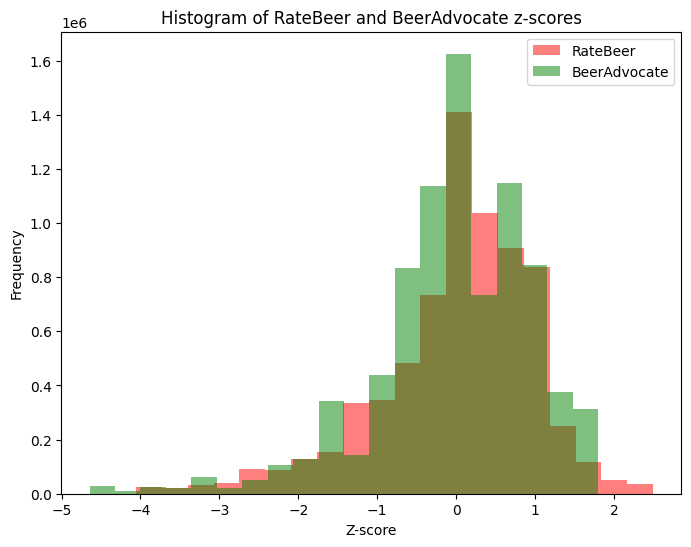

In [31]:
# Calcul du z-score pour la colonne 'ratings' dans ratings_rb_f
ratings_zscore_rb = (ratings_rb_f['rating'] - ratings_rb_f['rating'].mean()) / ratings_rb_f['rating'].std()

# Calcul du z-score pour la colonne 'ratings' dans ratings_ba_f
ratings_zscore_ba = (ratings_ba_f['rating'] - ratings_ba_f['rating'].mean()) / ratings_ba_f['rating'].std()

plt.figure(figsize=(8, 6))

plt.hist(ratings_zscore_rb, bins=20, color='red', alpha=0.5, label='RateBeer')
plt.hist(ratings_zscore_ba, bins=20, color='green', alpha=0.5, label='BeerAdvocate')

plt.title('Histogram of RateBeer and BeerAdvocate z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

We can see that RateBeer has more high notes.

In [52]:
ratings_ba_f[['palate', 'taste', 'aroma', "appearance", 'overall']].describe()

,palate,taste,aroma,appearance,overall
count,4.769675e+06,4.769675e+06,4.769675e+06,4.769675e+06,4.769675e+06
mean,3.865859e+00,3.903289e+00,3.869601e+00,3.937206e+00,3.900529e+00
std,6.083913e-01,6.433165e-01,6.204451e-01,5.584127e-01,6.161058e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.750000e+00,3.500000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


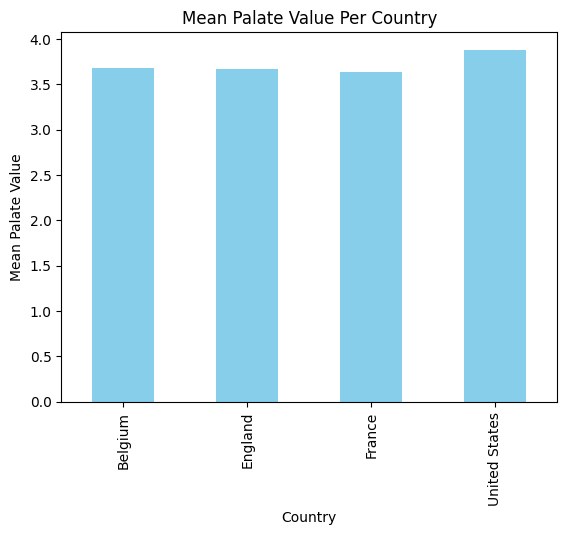

In [53]:
# Mean palate scores per countries 

selected_countries = ['United States', 'Belgium', 'England', 'France']
selected = ratings_ba_f[ratings_ba_f['location'].isin(selected_countries)]
palate_per_countries = selected.groupby('location')['palate'].mean()


palate_per_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Mean Palate Value')
plt.title('Mean Palate Value Per Country')
plt.show()

In [54]:
#To relieve RAM 
del ratings_ba_f
del ratings_rb_f